In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
from pandas.io.json import json_normalize
from classify_campaigns import classify_campaigns

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [3]:
start_dt = '2021-09-22'
end_dt = '2021-09-29'

(1) Plot Hourly Media Cost, Advertiser Revenue, Margin per Hour

(2) Plot Cohorted Installs by Hour -> Recommendation on Budget Allocation by Hour

(3) Is the Budget allocation/Spend/ following hours where we see high Inventory/Users/Installs 

(4) Are we exhausting Budget in the first few mins of every hour? 

(5) Are there DT campaigns that are exhausting budget Before EOD

Using the metadata campaign caps:

(1) Number of Campaigns capping Budgets

(2) % of revenue coming from capped campaigns

In [5]:
df = bigquery_client.query(f"""
select
    case when ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , case when cr_model = 'production' or ctr_model = 'production' then 'AutoPilot' else 'ML' end as bidder
    , date
    , extract(dayofweek from timestamp) as dow
    , extract(hour from timestamp) as hour
    , extract(minute from timestamp) as minute
    , country
    , count(case when event_type = 'clear' then 1 else NULL end)*2 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*2 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*2 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*2 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*2/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*2/1000 as bid
from stats.rows1
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(id,1) in ('0','1','2','3','4','5','6','7')
group by 1,2,3,4,5,6,7
""").to_dataframe()
df['date'] = df['date'].astype('datetime64')
df['spend'] = df['spend'].astype('float')
df['cost'] = df['cost'].astype('float')
df

buyer     bidder       date  dow  hour  minute country  impressions  \
0        RON         ML 2021-08-02    2    16      13    None            0   
1        RON         ML 2021-08-01    1     6       4    None            0   
2        RON         ML 2021-08-01    1     2      17    None            0   
3         DT  AutoPilot 2021-08-01    1     4      54      US         2258   
4        RON         ML 2021-08-01    1     6       2      CA          622   
...      ...        ...        ...  ...   ...     ...     ...          ...   
952598   RON  AutoPilot 2021-07-28    4    11      33      CI          108   
952599   RON  AutoPilot 2021-07-28    4    21      52      FI            0   
952600   RON  AutoPilot 2021-07-28    4    10       5      TN            2   
952601   RON  AutoPilot 2021-07-28    4    10      14      TN            2   
952602   RON         ML 2021-07-28    4    11      37      CH            2   

        clicks  installs  spend      cost        bid  
0            0         0    0.0  0.000000   0.000000  
1            0         0    0.0  0.000000   0.000000  
2            0         0    0.0  0.000000   0.000000  
3           78         6    8.1  8.320374  14.983695  
4            4         0    0.0  0.158108   0.163676  
...        ...       ...    ...       ...        ...  
952598       4         0    0.0  0.027066   0.027547  
952599       0         0    0.0  0.000000   0.000000  
952600       0         0    0.0  0.000236   0.000225  
952601       0         0    0.0  0.000308   0.000309  
952602       0         0    0.0  0.000120   0.000124  

[952603 rows x 13 columns]

In [152]:
tz = pd.read_csv('files/tz_bycountry.csv')
tz['offset_hrs'] = pd.to_numeric(tz['GMT Offset'].str[:3], errors = 'coerce') + pd.to_numeric(tz['GMT Offset'].str[-2:], errors = 'coerce')/60
tz_bycountry = tz.groupby('Country Code')['offset_hrs'].mean()
df_offset = pd.merge(df, tz_bycountry, how = 'left', left_on = 'country', right_on = 'Country Code')
df_offset

buyer     bidder       date  dow  hour  minute country  impressions  \
0         RON         ML 2021-04-08    5    16       2    None            0   
1         RON         ML 2021-04-08    5    18       9    None            0   
2         RON         ML 2021-04-09    6    22      19    None            0   
3         RON         ML 2021-04-11    1     4      11    None            0   
4         RON         ML 2021-04-11    1    19      28    None            0   
...       ...        ...        ...  ...   ...     ...     ...          ...   
1900560    DT  AutoPilot 2021-05-05    4     8      25      BR          112   
1900561   RON         ML 2021-05-05    4    23       8      AU          384   
1900562    DT         ML 2021-05-05    4     3      57      DE          288   
1900563   RON         ML 2021-05-05    4    12       8      ES           16   
1900564   RON  AutoPilot 2021-05-05    4    15       6      EE           32   

         clicks  installs  spend      cost       bid  offset_hrs  
0             0         0    NaN  0.000000  0.000000         NaN  
1             0         0    NaN  0.000000  0.000000         NaN  
2             0         0    NaN  0.000000  0.000000         NaN  
3             0         0    NaN  0.000000  0.000000         NaN  
4             0         0    NaN  0.000000  0.000000         NaN  
...         ...       ...    ...       ...       ...         ...  
1900560       0         0    0.0  0.190032  0.198375   -3.500000  
1900561       0         0    0.0  0.094153  0.101319    9.645833  
1900562       0         0    0.0  0.230375  0.243917    2.000000  
1900563       0         0    0.0  0.016440  0.016372    1.666667  
1900564       0         0    0.0  0.003148  0.003301    3.000000  

[1900565 rows x 14 columns]

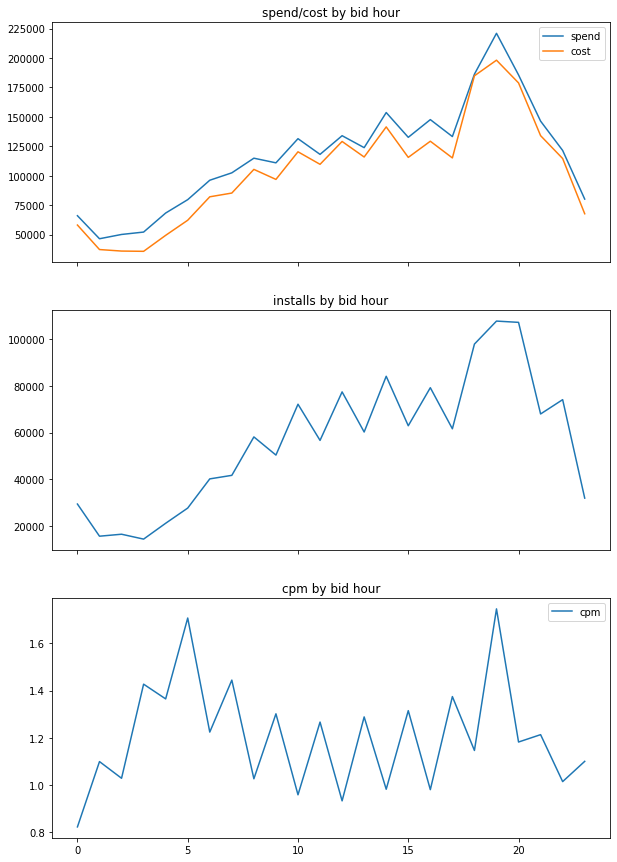

In [163]:
df_offset['hour_local'] = round(df_offset.hour + df_offset.offset_hrs.astype('int', errors = 'ignore'),0).astype(int, errors = 'ignore')
df_offset.loc[df_offset.hour_local > 23, 'hour_local'] = df_offset['hour_local'] - 24
df_offset.loc[df_offset.hour_local < 0, 'hour_local'] = df_offset['hour_local'] + 24

pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost','bid'], index = 'hour_local', aggfunc = np.sum)
pvt['bpm'] = 1000*pvt['bid']/pvt['impressions']
pvt['cpm'] = 1000*pvt['cost']/pvt['impressions']

fig, ax = plt.subplots(3,1, figsize = (10,15), sharex = True)
ax[0].plot(pvt[['spend','cost']])
ax[0].set_title('spend/cost by bid hour')
ax[0].legend(['spend','cost'])
ax[1].plot(pvt[['installs']])
ax[1].set_title('installs by bid hour')
ax[2].plot(pvt[['cpm']])
ax[2].set_title('cpm by bid hour')
ax[2].legend(['cpm'])

Text(0.5, 1.0, 'cpm by bid hour (local) (AP)')

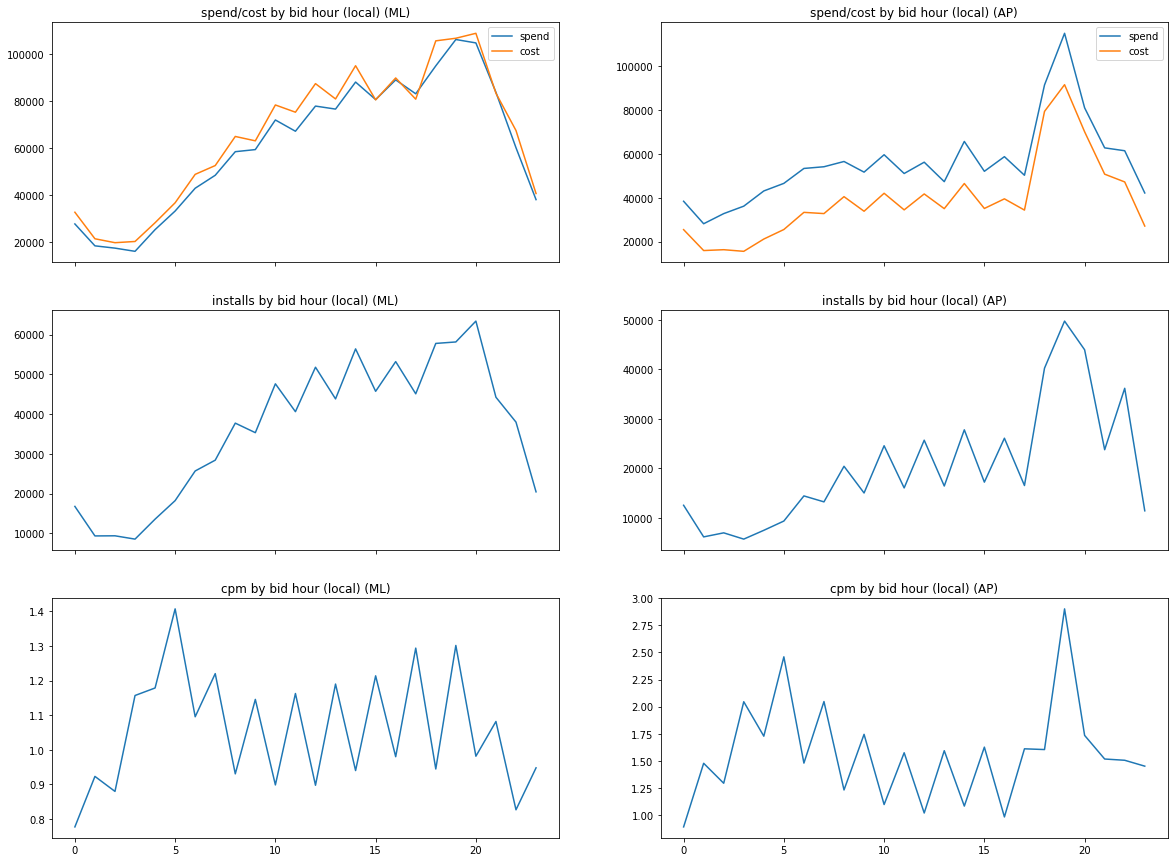

In [166]:
pvt_ml = df_offset[df_offset.bidder == 'ML'].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour_local', aggfunc = np.sum)
pvt_ap = df_offset[df_offset.bidder == 'AutoPilot'].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour_local', aggfunc = np.sum)
pvt_ml['cpm'] = 1000*pvt_ml['cost']/pvt_ml['impressions']
pvt_ap['cpm'] = 1000*pvt_ap['cost']/pvt_ap['impressions']

fig, ax = plt.subplots(3,2, figsize = (20,15), sharex = True)
ax[0,0].plot(pvt_ml[['spend','cost']])
ax[0,0].set_title('spend/cost by bid hour (local) (ML)')
ax[0,0].legend(['spend','cost'])
ax[1,0].plot(pvt_ml[['installs']])
ax[1,0].set_title('installs by bid hour (local) (ML)')
ax[2,0].plot(pvt_ml[['cpm']])
ax[2,0].set_title('cpm by bid hour (local) (ML)')
ax[0,1].plot(pvt_ap[['spend','cost']])
ax[0,1].set_title('spend/cost by bid hour (local) (AP)')
ax[0,1].legend(['spend','cost'])
ax[1,1].plot(pvt_ap[['installs']])
ax[1,1].set_title('installs by bid hour (local) (AP)')
ax[2,1].plot(pvt_ap[['cpm']])
ax[2,1].set_title('cpm by bid hour (local) (AP)')

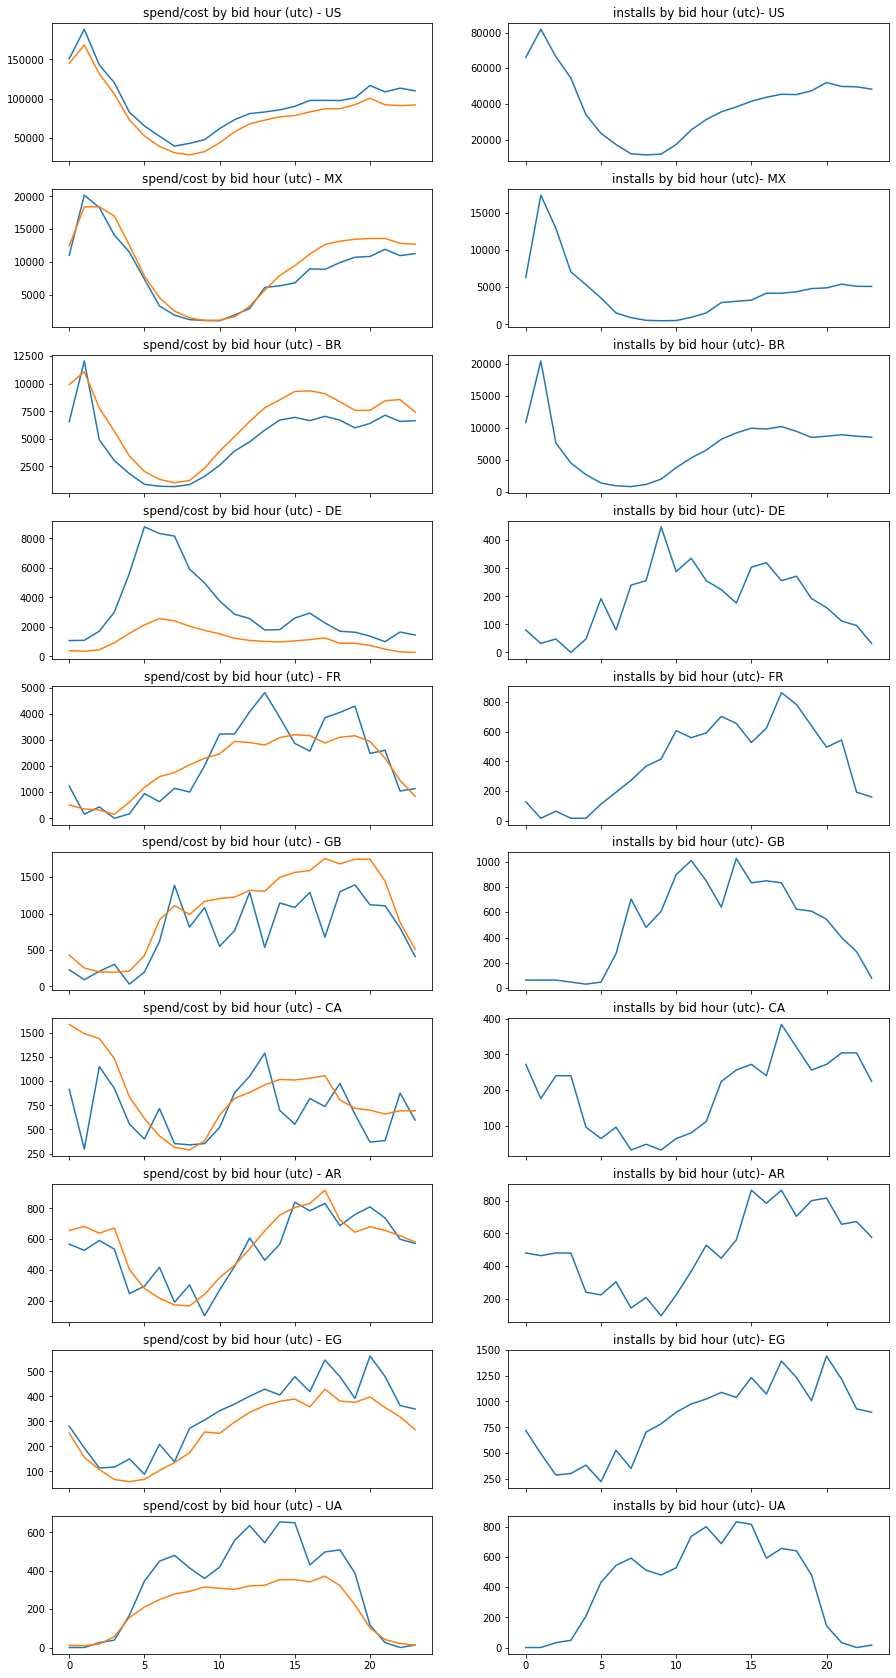

In [9]:
top_countries = df_offset.groupby('country')['spend'].sum().sort_values(ascending = False).index[:10].to_list()

fig, ax = plt.subplots(len(top_countries),2, figsize = (15,30), sharex = True)
    
for n in range(len(top_countries)):
    df_filtered = df_offset[df_offset.country == top_countries[n]]
    pvt = df_filtered.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour', aggfunc = np.sum)

    ax[n,0].plot(pvt[['spend','cost']])
    ax[n,0].set_title('spend/cost by bid hour (utc) - {}'.format(top_countries[n]))
    ax[n,1].plot(pvt[['installs']])
    ax[n,1].set_title('installs by bid hour (utc)- {}'.format(top_countries[n]))

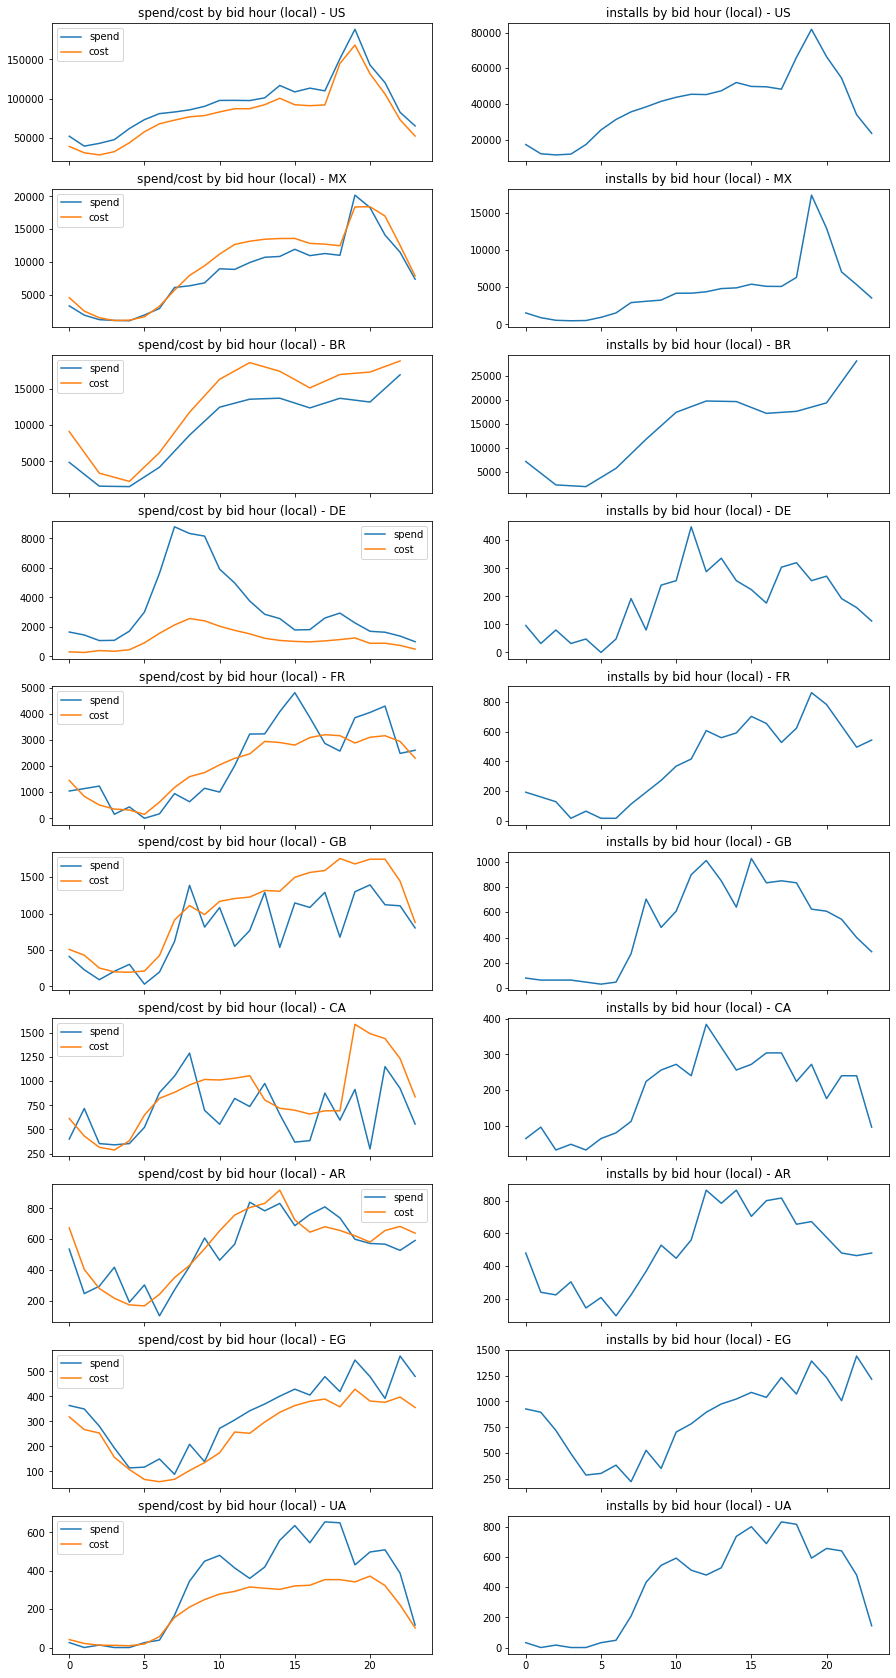

In [114]:


fig, ax = plt.subplots(len(top_countries),2, figsize = (15,30), sharex = True)
    
for n in range(len(top_countries)):
    df_filtered = df_offset[df_offset.country == top_countries[n]]
    pvt = df_filtered.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour_local', aggfunc = np.sum)

    ax[n,0].plot(pvt[['spend','cost']])
    ax[n,0].set_title('spend/cost by bid hour (local) - {}'.format(top_countries[n]))
    ax[n,0].legend(['spend','cost'])
    ax[n,1].plot(pvt[['installs']])
    ax[n,1].set_title('installs by bid hour (local) - {}'.format(top_countries[n]))

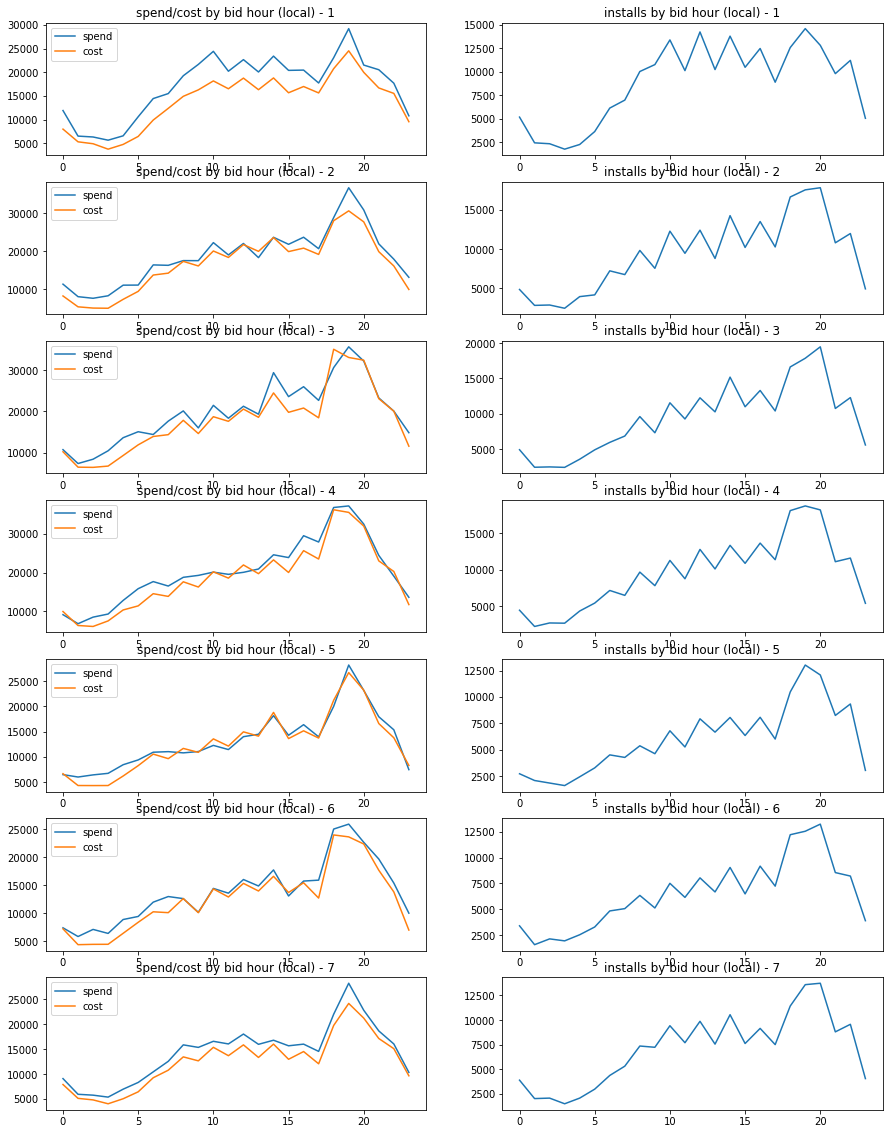

In [168]:
fig, ax = plt.subplots(7,2, figsize = (15,20))

for n in list(range(1,8)):
    df_filtered = df_offset[df_offset.dow == n]
    pvt = df_filtered.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour_local', aggfunc = np.sum)

    ax[n-1,0].plot(pvt[['spend','cost']])
    ax[n-1,0].set_title('spend/cost by bid hour (local) - {}'.format(n))
    ax[n-1,0].legend(['spend','cost'])
    ax[n-1,1].plot(pvt[['installs']])
    ax[n-1,1].set_title('installs by bid hour (local) - {}'.format(n))

(0.0, 2.0)

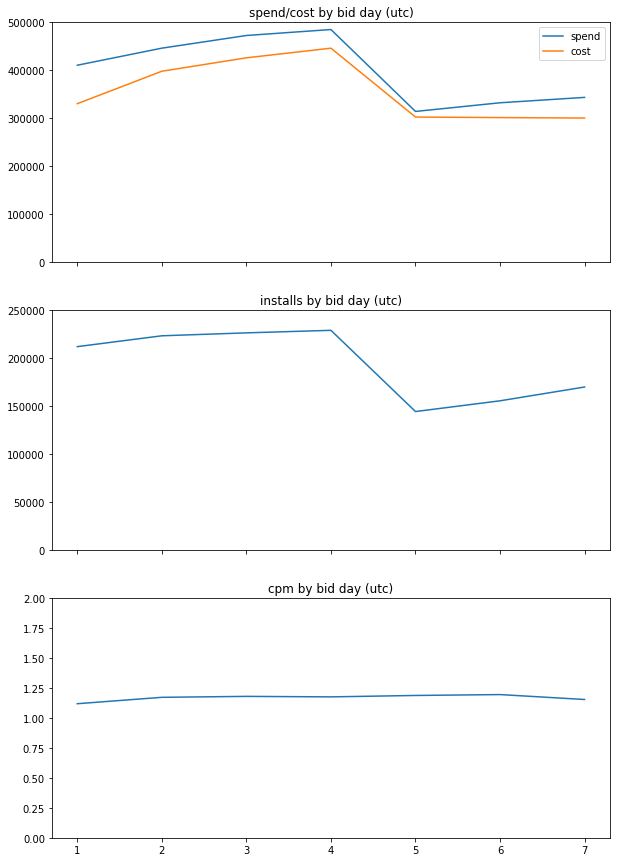

In [174]:
fig, ax = plt.subplots(3,1, figsize = (10,15), sharex = True)

pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'dow', aggfunc = np.sum)
pvt['cpm'] = 1000*pvt['cost']/pvt['impressions']
ax[0].plot(pvt[['spend','cost']])
ax[0].set_title('spend/cost by bid day (utc)')
ax[0].legend(['spend','cost'])
ax[0].set_ylim(0,500000)
ax[1].plot(pvt[['installs']])
ax[1].set_title('installs by bid day (utc)')
ax[1].set_ylim(0,250000)
ax[2].plot(pvt[['cpm']])
ax[2].set_title('cpm by bid day (utc)')
ax[2].set_ylim(0,2)

(0.0, 2.0)

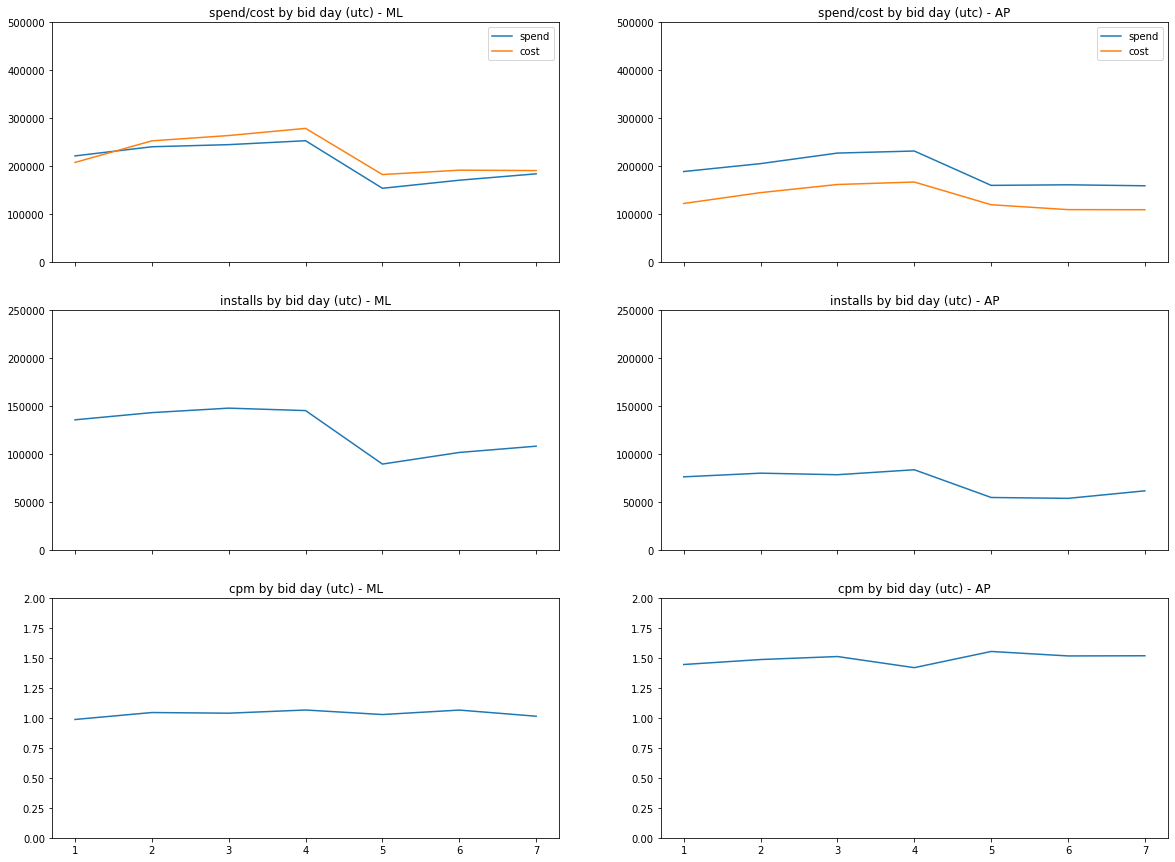

In [179]:
fig, ax = plt.subplots(3,2, figsize = (20,15), sharex = True)

pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = ['bidder','dow'], aggfunc = np.sum)
pvt['cpm'] = 1000*pvt['cost']/pvt['impressions']
ax[0,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML',['spend','cost']].droplevel(0))
ax[0,0].set_title('spend/cost by bid day (utc) - ML')
ax[0,0].legend(['spend','cost'])
ax[0,0].set_ylim(0,500000)
ax[1,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML',['installs']].droplevel(0))
ax[1,0].set_title('installs by bid day (utc) - ML')
ax[1,0].set_ylim(0,250000)
ax[2,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML',['cpm']].droplevel(0))
ax[2,0].set_title('cpm by bid day (utc) - ML')
ax[2,0].set_ylim(0,2)
ax[0,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot',['spend','cost']].droplevel(0))
ax[0,1].set_title('spend/cost by bid day (utc) - AP')
ax[0,1].legend(['spend','cost'])
ax[0,1].set_ylim(0,500000)
ax[1,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot',['installs']].droplevel(0))
ax[1,1].set_title('installs by bid day (utc) - AP')
ax[1,1].set_ylim(0,250000)
ax[2,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot',['cpm']].droplevel(0))
ax[2,1].set_title('cpm by bid day (utc) - AP')
ax[2,1].set_ylim(0,2)

## intra hour

Text(0.5, 1.0, 'impressions by minute of hour')

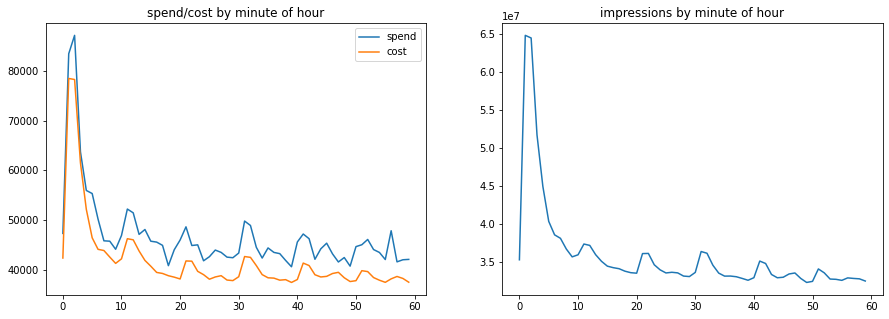

In [626]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'minute', aggfunc = np.sum)

ax[0].plot(pvt[['spend','cost']])
ax[0].set_title('spend/cost by minute of hour')
ax[0].legend(['spend','cost'])
ax[1].plot(pvt[['impressions']])
ax[1].set_title('impressions by minute of hour')

Text(0.5, 1.0, 'impressions by minute of hour (AP)')

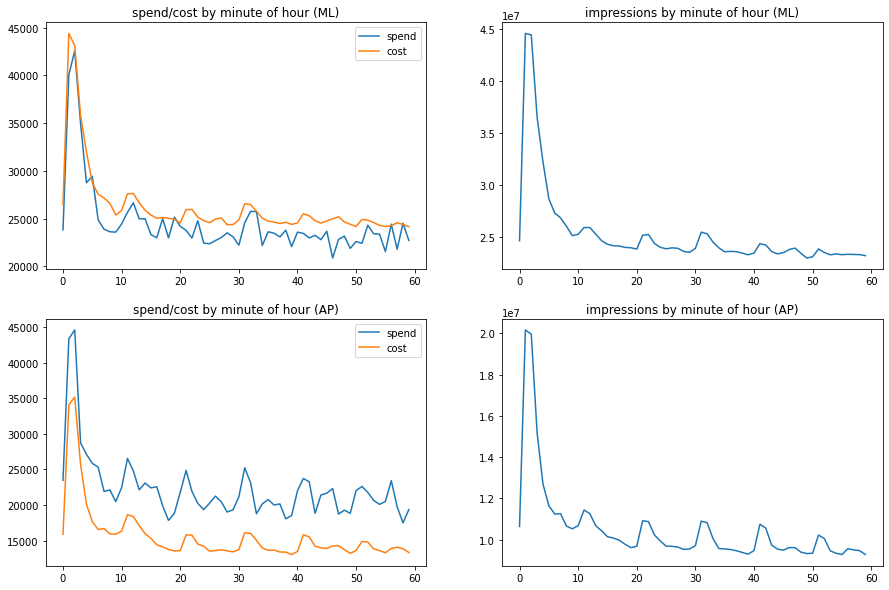

In [134]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = ['bidder','minute'], aggfunc = np.sum)

ax[0,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML', ['spend','cost']].droplevel(0))
ax[0,0].set_title('spend/cost by minute of hour (ML)')
ax[0,0].legend(['spend','cost'])
ax[0,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML', ['impressions']].droplevel(0))
ax[0,1].set_title('impressions by minute of hour (ML)')
ax[1,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot', ['spend','cost']].droplevel(0))
ax[1,0].set_title('spend/cost by minute of hour (AP)')
ax[1,0].legend(['spend','cost'])
ax[1,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot', ['impressions']].droplevel(0))
ax[1,1].set_title('impressions by minute of hour (AP)')

Text(0.5, 1.0, 'impression/install share of voice by minute of hour (AP)')

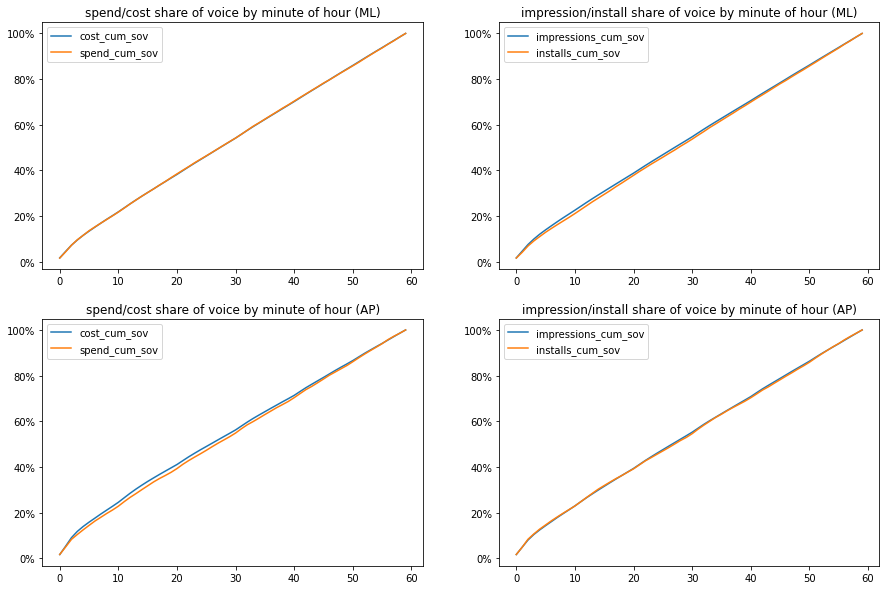

In [132]:
pvt['cost_cum_sov'] = pvt['cost'].groupby('bidder').cumsum()/pvt['cost'].groupby('bidder').sum()
pvt['spend_cum_sov'] = pvt['spend'].groupby('bidder').cumsum()/pvt['spend'].groupby('bidder').sum()
pvt['impressions_cum_sov'] = pvt['impressions'].groupby('bidder').cumsum()/pvt['impressions'].groupby('bidder').sum()
pvt['installs_cum_sov'] = pvt['installs'].groupby('bidder').cumsum()/pvt['installs'].groupby('bidder').sum()

fig, ax = plt.subplots(2,2, figsize = (15,10))
ax[0,0].plot(100*pvt.loc[pvt.index.get_level_values(0) == 'ML', ['cost_cum_sov','spend_cum_sov']].droplevel(0))
ax[0,0].legend(['cost_cum_sov','spend_cum_sov'])
ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,0].set_title('spend/cost share of voice by minute of hour (ML)')
ax[0,1].plot(100*pvt.loc[pvt.index.get_level_values(0) == 'ML', ['impressions_cum_sov','installs_cum_sov']].droplevel(0))
ax[0,1].legend(['impressions_cum_sov','installs_cum_sov'])
ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,1].set_title('impression/install share of voice by minute of hour (ML)')
ax[1,0].plot(100*pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot', ['cost_cum_sov','spend_cum_sov']].droplevel(0))
ax[1,0].legend(['cost_cum_sov','spend_cum_sov'])
ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1,0].set_title('spend/cost share of voice by minute of hour (AP)')
ax[1,1].plot(100*pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot', ['impressions_cum_sov','installs_cum_sov']].droplevel(0))
ax[1,1].legend(['impressions_cum_sov','installs_cum_sov'])
ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1,1].set_title('impression/install share of voice by minute of hour (AP)')

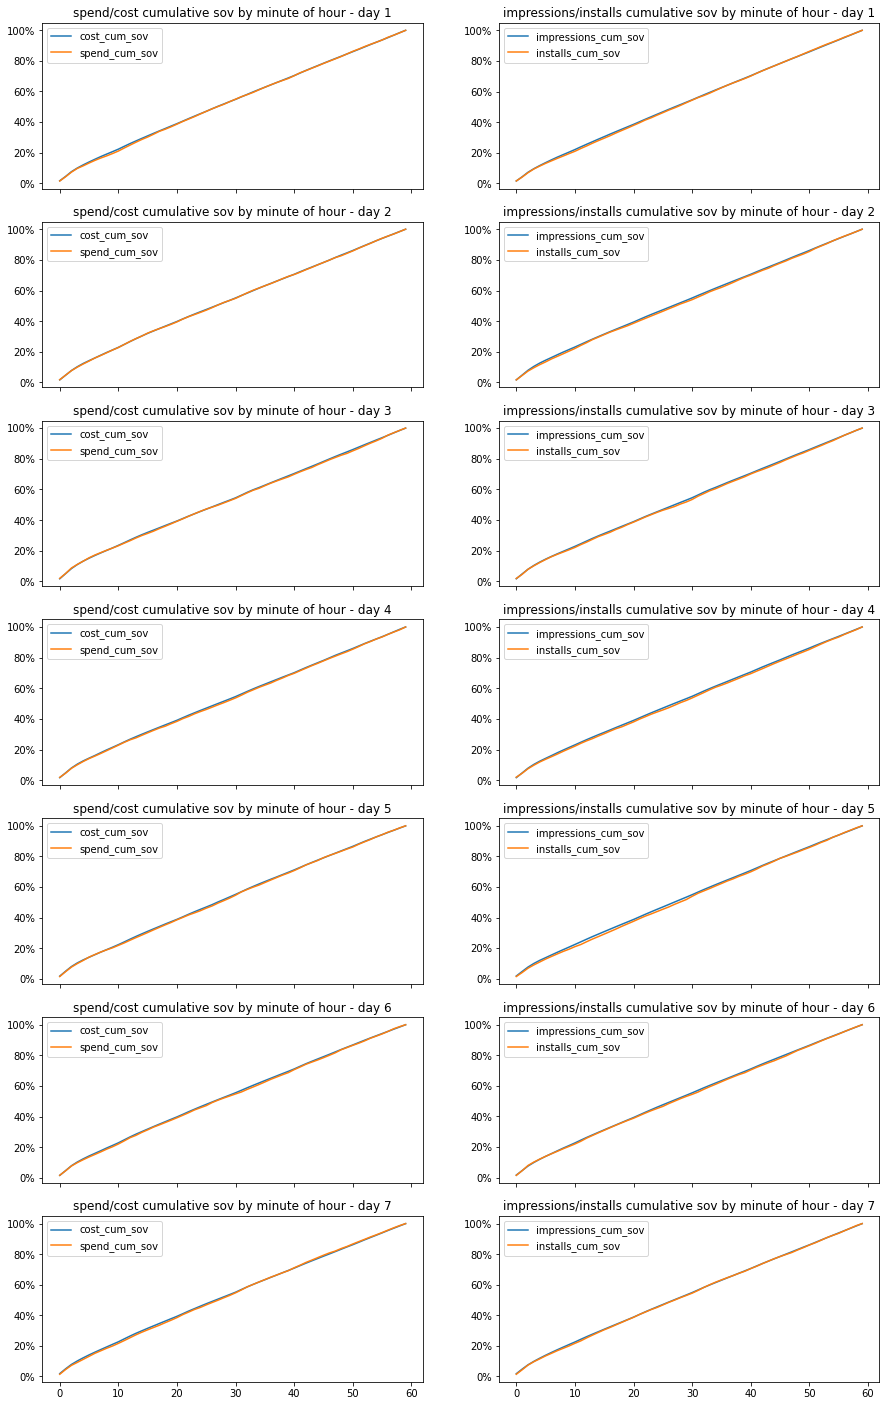

In [20]:
fig, ax = plt.subplots(7,2, figsize = (15,25), sharex = True)

for n in list(range(1,8)):
    df_filtered = df_offset[df_offset.dow == n]
    pvt = df_filtered.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'minute', aggfunc = np.sum)
    pvt['cost_cum_sov'] = pvt['cost'].cumsum()/pvt['cost'].sum()
    pvt['spend_cum_sov'] = pvt['spend'].cumsum()/pvt['spend'].sum()
    pvt['impressions_cum_sov'] = pvt['impressions'].cumsum()/pvt['impressions'].sum()
    pvt['installs_cum_sov'] = pvt['installs'].cumsum()/pvt['installs'].sum()
    ax[n-1,0].plot(100*pvt[['cost_cum_sov','spend_cum_sov']])
    ax[n-1,0].legend(['cost_cum_sov','spend_cum_sov'])
    ax[n-1,0].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[n-1,0].set_title('spend/cost cumulative sov by minute of hour - day {}'.format(n))
    ax[n-1,1].plot(100*pvt[['impressions_cum_sov','installs_cum_sov']])
    ax[n-1,1].legend(['impressions_cum_sov','installs_cum_sov'])
    ax[n-1,1].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[n-1,1].set_title('impressions/installs cumulative sov by minute of hour - day {}'.format(n))

## Campaign capping hour

In [33]:
df_capping = bigquery_client.query(f"""
select
    case when r.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , date(etimestamp) as date
    , extract(dayofweek from etimestamp) as dow
    , extract(hour from etimestamp) as hour
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(case when event_type = 'install' then revenue else 0 end) as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)/1000 as bid
from stats.rows1 r
join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
where 
    date(etimestamp) >= '{start_dt}'
    and date(etimestamp) <= '{end_dt}'
group by 1,2,3,4,5,6
""").to_dataframe()
df_capping['date'] = df_capping['date'].astype('datetime64')
df_capping['spend'] = df_capping['spend'].astype('float')
df_capping['cost'] = df_capping['cost'].astype('float')
df_capping

buyer       date  dow  hour                 ssb_campaign_uuid  \
0        RON 2021-09-22    4    13  13dd61de277e222ed331e9cbb3220be5   
1        RON 2021-09-22    4    11  a3620b063931690aaa39d26e30aa4f1b   
2        RON 2021-09-22    4    15  ed474672a04579cc5709b69125c823ee   
3         DT 2021-09-22    4    18  ebaef6f00019bc072cae96b5052f62d2   
4         DT 2021-09-22    4     7  0c0ded719c3afb709b937d7a19e98991   
...      ...        ...  ...   ...                               ...   
133902    DT 2021-09-29    4    21  ad97eb5c0e5e22bdb20c0c8d52d43c97   
133903   RON 2021-09-29    4    21  c1d1990e5ce0df5165e64e402496305d   
133904   RON 2021-09-29    4    17  39f15399ad3a2b12e63a9cc8982bdcf6   
133905   RON 2021-09-29    4    23  c97d0a0bcb658ecf40ae94db90e33322   
133906   RON 2021-09-29    4    23  5aa7ef1cb2779480cd38b4ec11522f37   

                                            campaign_name  impressions  \
0                      ES Kidjo IOS Interstitial Movistar          229   
1                           131102 320x480 DE IOS MW -55%          634   
2       Fashion Battle - Dress to win - US - Android -...         1332   
3                  Blind Ferret - Rewarded Play - US - UA          305   
4                    Position Mobile - NewsHome - US - UA         4508   
...                                                   ...          ...   
133902              Pandora - Pandora - US - 2 - BLU test          532   
133903  FR - Bob esponja - sfr, bouygues, orange - vid...           30   
133904                      160412 1024x768 US IOS MW 20%            0   
133905                                 High Heels!_US_DRD          539   
133906                     DV-KSA-Zain-Games-iOS-Inmobi-W          181   

        clicks  installs  spend       cost        bid  
0           18         0   0.00   0.691790   0.692338  
1            0         0   0.00   3.907667   6.703671  
2          227        56  20.10  15.034397  15.029171  
3           54         5  13.75  14.252838  14.254789  
4           43         6   8.00   5.240336   5.267998  
...        ...       ...    ...        ...        ...  
133902       6         1   2.30   1.995910   1.993812  
133903       5         0   0.00   0.022809   0.022708  
133904       0         0   0.00   0.000000   0.000000  
133905     156        27   8.40   8.590395   8.589413  
133906      50         0   0.00   0.460280   0.459730  

[133907 rows x 12 columns]

In [34]:
df_capping['media_cost'] = df_capping['cost']*1.25

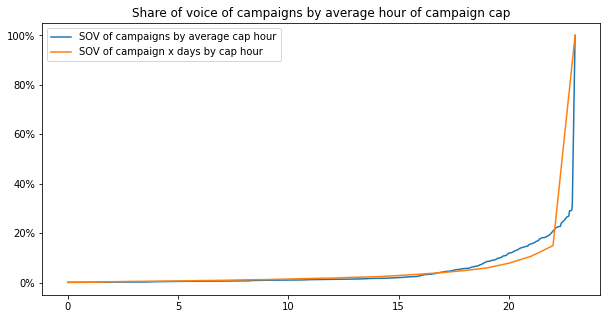

In [35]:
df_capping['cap_hour'] = df_capping[df_capping.impressions > 0].groupby(['ssb_campaign_uuid','date'])['hour'].transform('max')
cap_hour_by_campaign_date = df_capping.pivot_table(values = ['cap_hour'], index = ['ssb_campaign_uuid','date'], aggfunc = 'max').reset_index()
cap_hour_campaign_counts = pd.DataFrame(cap_hour_by_campaign_date.groupby('cap_hour')['ssb_campaign_uuid'].count())
cap_hour_campaign_counts['campaign_day_sov'] = cap_hour_campaign_counts['ssb_campaign_uuid'].cumsum()/cap_hour_campaign_counts['ssb_campaign_uuid'].sum()

cap_hour_by_campaign_avg = cap_hour_by_campaign_date.groupby('ssb_campaign_uuid')['cap_hour'].mean().reset_index()
avg_cap_hour_counts = pd.DataFrame(cap_hour_by_campaign_avg.groupby('cap_hour')['ssb_campaign_uuid'].count())
avg_cap_hour_counts['avg_campaign_sov'] = avg_cap_hour_counts['ssb_campaign_uuid'].cumsum()/avg_cap_hour_counts['ssb_campaign_uuid'].sum()

fig, ax = plt.subplots(figsize = (10,5)) 
ax.plot(100*avg_cap_hour_counts[['avg_campaign_sov']])
ax.plot(100*cap_hour_campaign_counts[['campaign_day_sov']])
ax.set_title('Share of voice of campaigns by average hour of campaign cap')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(['SOV of campaigns by average cap hour', 'SOV of campaign x days by cap hour'])

Text(0.5, 1.0, 'Share of voice of campaign x days by hour of campaign cap (DT only)')

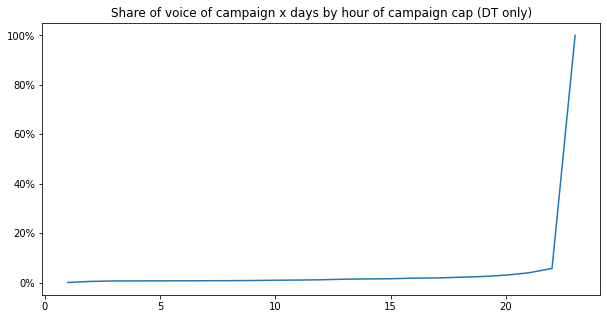

In [36]:
cap_hour_by_campaign_date = df_capping[df_capping.buyer == 'DT'].pivot_table(values = ['cap_hour'], index = ['ssb_campaign_uuid','date'], aggfunc = 'max').reset_index()
cap_hour_counts = pd.DataFrame(cap_hour_by_campaign_date.groupby('cap_hour')['ssb_campaign_uuid'].count())
cap_hour_counts['sov'] = cap_hour_counts['ssb_campaign_uuid'].cumsum()/cap_hour_counts['ssb_campaign_uuid'].sum()
fig, ax = plt.subplots(figsize = (10,5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.plot(100*cap_hour_counts['sov'])
ax.set_title('Share of voice of campaign x days by hour of campaign cap (DT only)')


([<matplotlib.axis.XTick at 0x7fb966de1fa0>,
 [Text(1, 0, '09/22'),
  Text(2, 0, '09/23'),
  Text(3, 0, '09/24'),
  Text(4, 0, '09/25'),
  Text(5, 0, '09/26'),
  Text(6, 0, '09/27'),
  Text(7, 0, '09/28'),
  Text(8, 0, '09/29')])

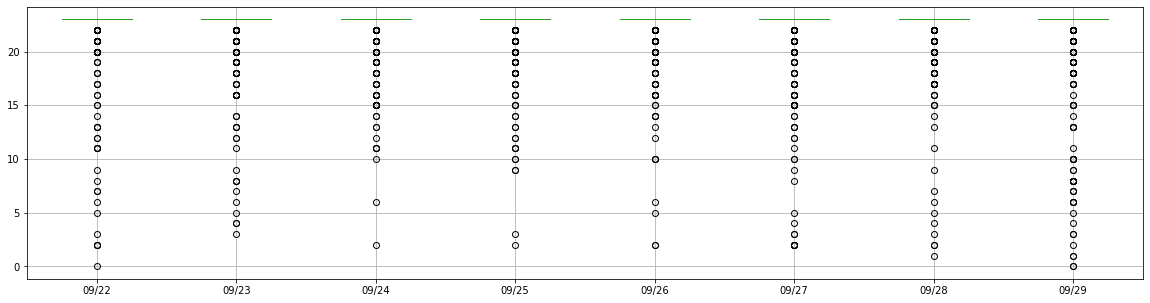

In [37]:
cap_hour_by_date_campaign = df_capping.pivot_table(values = 'cap_hour', index = 'ssb_campaign_uuid', columns = 'date', aggfunc = 'max')
cap_hour_by_date_campaign.columns = cap_hour_by_date_campaign.columns.astype('datetime64[ns]')
fig, ax = plt.subplots(figsize = (20,5))
cap_hour_by_date_campaign.boxplot(ax=ax)
plt.xticks(np.arange(cap_hour_by_date_campaign.shape[1])[::1]+1, cap_hour_by_date_campaign.columns[::1].strftime('%m/%d'))


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without 

[(0.0, 30.0)]

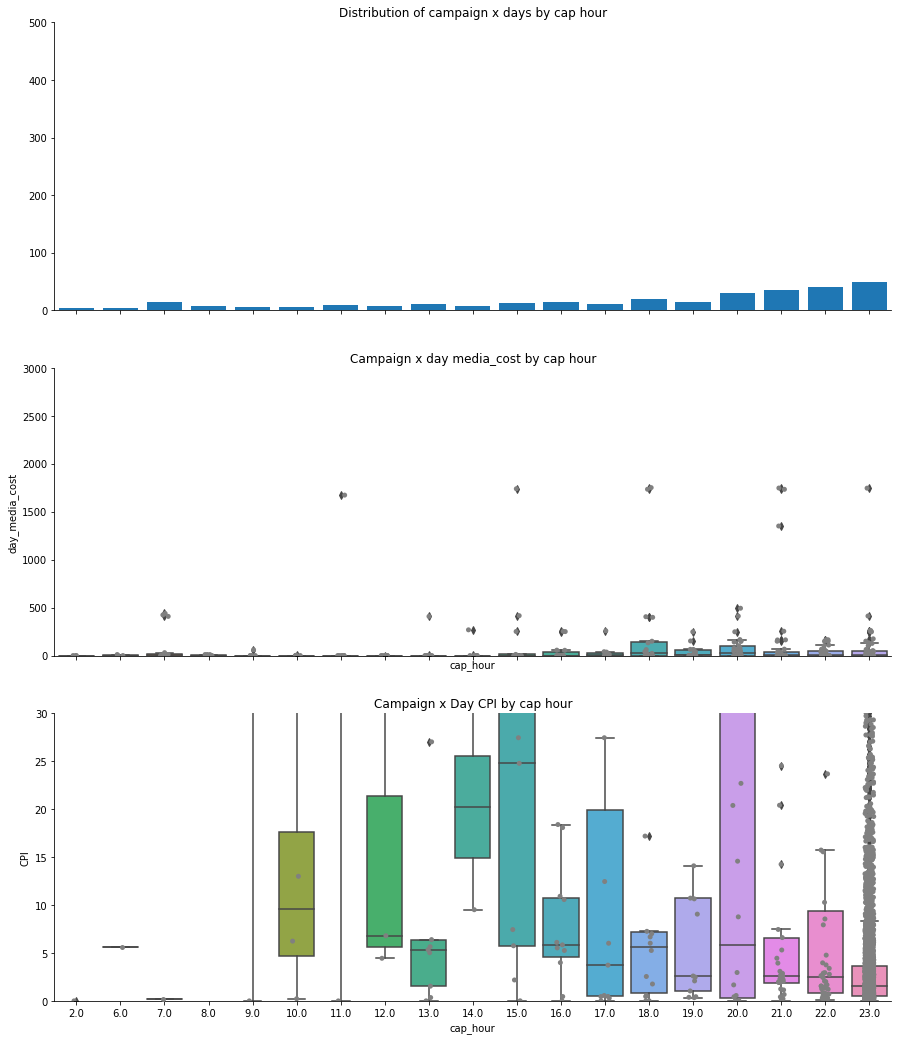

In [38]:
df_capping['day_media_cost'] = df_capping.groupby(['ssb_campaign_uuid','date'])['media_cost'].transform('sum')
df_capping['day_spend'] = df_capping.groupby(['ssb_campaign_uuid','date'])['spend'].transform('sum')
df_capping['day_installs'] = df_capping.groupby(['ssb_campaign_uuid','date'])['installs'].transform('sum')

cap_hour_by_campaign_date = df_capping[df_capping.day_media_cost > 0].pivot_table(values = ['cap_hour','day_media_cost','day_installs'], index = ['ssb_campaign_uuid','date'], aggfunc = 'mean').reset_index()
cap_hour_counts = cap_hour_by_campaign_date.pivot_table(values = ['ssb_campaign_uuid','day_media_cost'], index = ['cap_hour'], aggfunc = {'ssb_campaign_uuid':'count', 'day_media_cost':'mean'})
cap_hour_by_campaign_date['CPI'] = cap_hour_by_campaign_date['day_media_cost']/cap_hour_by_campaign_date['day_installs']

fig, ax = plt.subplots(3,1, figsize = (15,18), sharex = True)
ax[0].bar(cap_hour_counts.index, cap_hour_counts['ssb_campaign_uuid'])
ax[0].set_title('Distribution of campaign x days by cap hour')
ax[0].set_ylim(0,500)
ax[1].set_title('Campaign x day media_cost by cap hour')
sns.stripplot('cap_hour', 'day_media_cost', data = cap_hour_by_campaign_date, ax = ax[1], color = 'grey')
sns.boxplot('cap_hour', 'day_media_cost', data = cap_hour_by_campaign_date, ax = ax[1])
ax[1].set(ylim = (0,3000))

cap_hour_by_campaign_date = cap_hour_by_campaign_date.loc[cap_hour_by_campaign_date.day_installs > 0]
ax[2].set_title('Campaign x Day CPI by cap hour')
sns.stripplot('cap_hour', 'CPI', data = cap_hour_by_campaign_date, ax = ax[2], color = 'grey')
sns.boxplot('cap_hour', 'CPI', data = cap_hour_by_campaign_date, ax = ax[2])
sns.despine()
ax[2].set(ylim = (0,30))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without 

[(0.0, 30.0)]

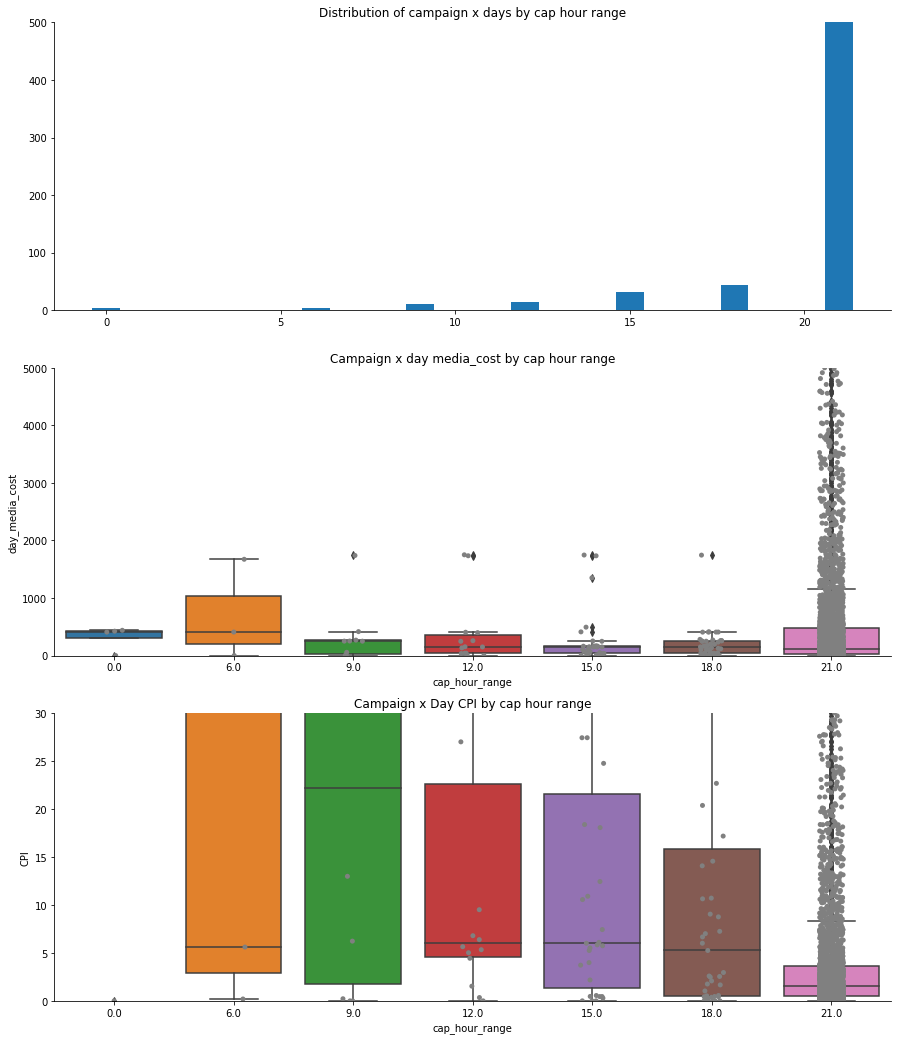

In [39]:
cap_hour_by_campaign_date['cap_hour_range'] = 3*np.floor(cap_hour_by_campaign_date['cap_hour']/3)

cap_hour_counts = cap_hour_by_campaign_date.pivot_table(values = ['ssb_campaign_uuid','day_media_cost'], index = ['cap_hour_range'], aggfunc = {'ssb_campaign_uuid':'count', 'day_media_cost':'mean'})
cap_hour_by_campaign_date['CPI'] = cap_hour_by_campaign_date['day_media_cost']/cap_hour_by_campaign_date['day_installs']

fig, ax = plt.subplots(3,1, figsize = (15,18))
ax[0].bar(cap_hour_counts.index, cap_hour_counts['ssb_campaign_uuid'])
ax[0].set_title('Distribution of campaign x days by cap hour range')
ax[0].set_ylim(0,500)
ax[1].set_title('Campaign x day media_cost by cap hour range')
sns.stripplot('cap_hour_range', 'day_media_cost', data = cap_hour_by_campaign_date, ax = ax[1], color = 'grey')
sns.boxplot('cap_hour_range', 'day_media_cost', data = cap_hour_by_campaign_date, ax = ax[1])
ax[1].set(ylim = (0,5000))

cap_hour_by_campaign_date = cap_hour_by_campaign_date.loc[cap_hour_by_campaign_date.day_installs > 0]
ax[2].set_title('Campaign x Day CPI by cap hour range')
sns.stripplot('cap_hour_range', 'CPI', data = cap_hour_by_campaign_date, ax = ax[2], color = 'grey')
sns.boxplot('cap_hour_range', 'CPI', data = cap_hour_by_campaign_date, ax = ax[2])
sns.despine()
ax[2].set(ylim = (0,30))

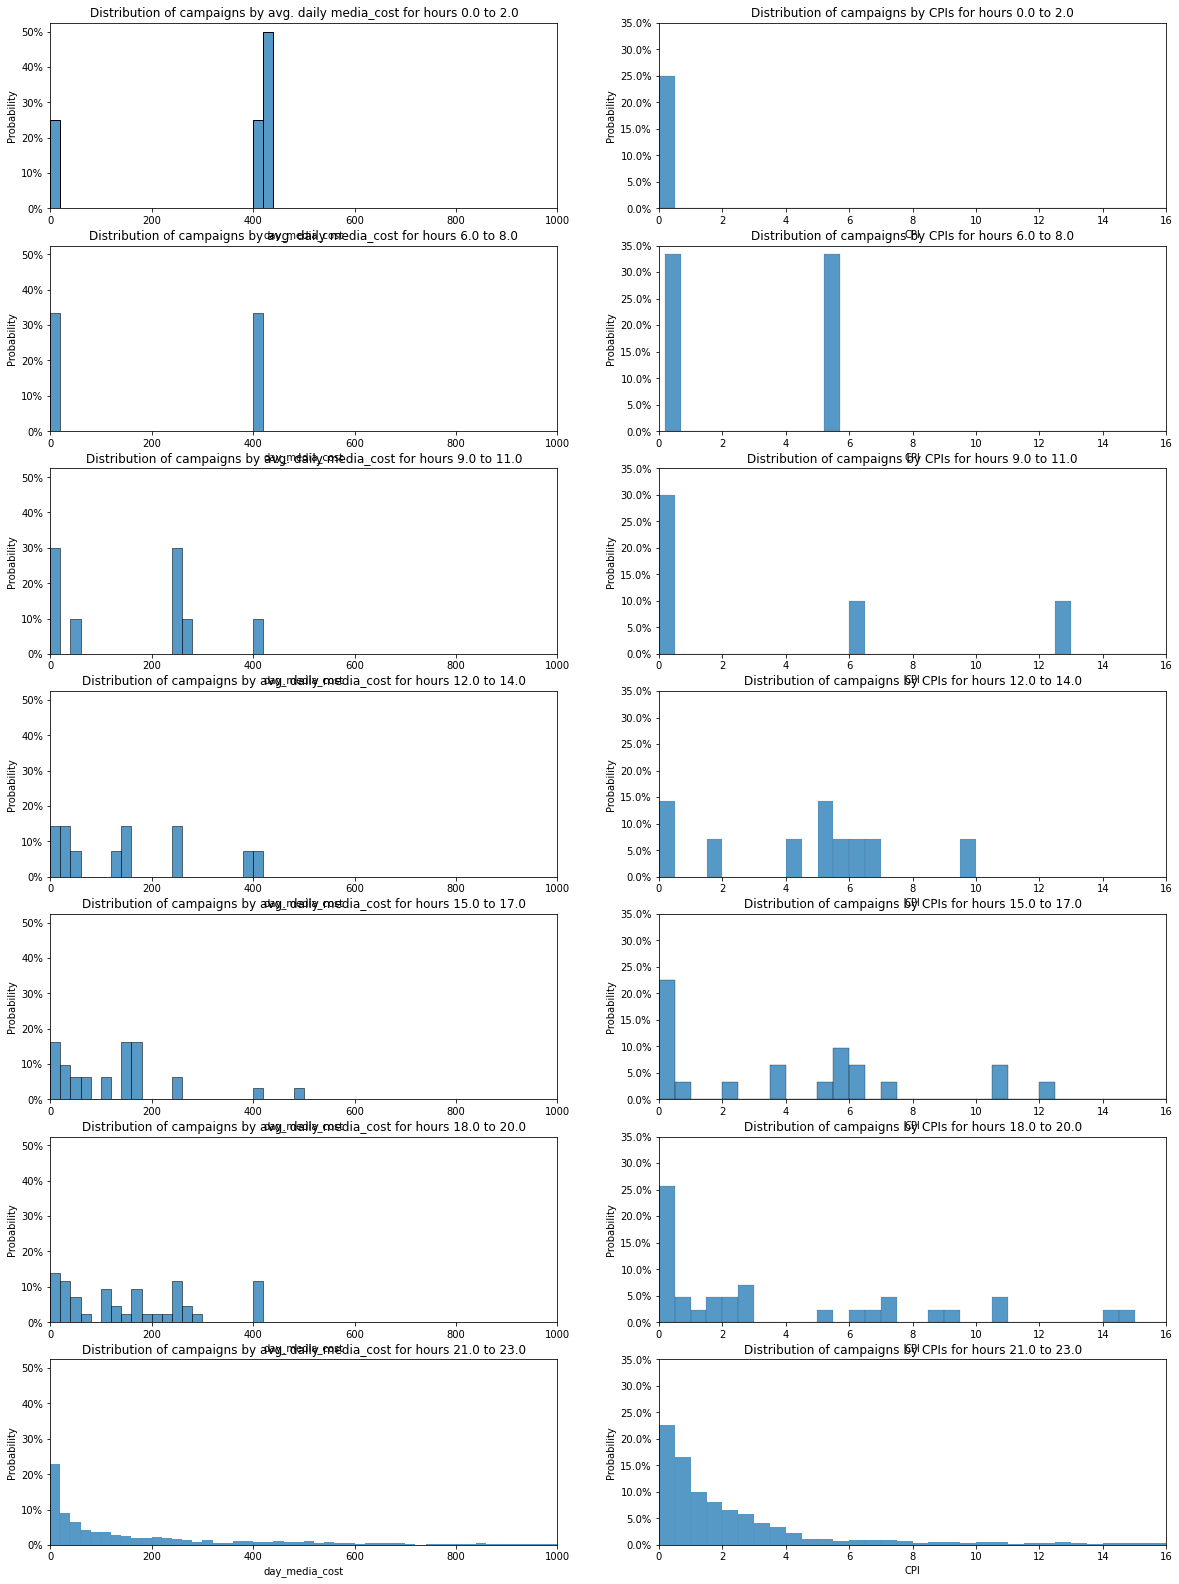

In [40]:
cap_hour_range_list = cap_hour_by_campaign_date.cap_hour_range.sort_values().unique().tolist()

# ax = sns.displot(cap_hour_by_campaign_date.loc[cap_hour_by_campaign_date.cap_hour_range < 24], x="day_media_cost", hue="cap_hour_range", kind="kde")
# ax.set(ylim=(0, .0001))

fig, ax = plt.subplots(len(cap_hour_range_list),2, figsize = (20, 4*len(cap_hour_range_list)), sharey = 'col')

for c in cap_hour_range_list:
    hist_data = cap_hour_by_campaign_date.loc[(cap_hour_by_campaign_date.cap_hour_range == c) & (cap_hour_by_campaign_date.day_installs > 0)]
    n = cap_hour_range_list.index(c)
    sns.histplot(x = 'day_media_cost', data = hist_data, ax = ax[n,0], binwidth = 20, stat = 'probability')
    ax[n,0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax[n,0].set_title(f'Distribution of campaigns by avg. daily media_cost for hours {c} to {c+2}')
    ax[n,0].set_xlim(0,1000)
    sns.histplot(x = 'CPI', data = hist_data, ax = ax[n,1], binwidth = .5, stat = 'probability')
    ax[n,1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax[n,1].set_xlim(0,16)
    ax[n,1].set_title(f'Distribution of campaigns by CPIs for hours {c} to {c+2}')
    


In [41]:
df_campaigns = bigquery_client.query(f"""
select
    *
from metadata.campaigns c
""").to_dataframe()
json_struct = df_campaigns['extra_data'].apply(json.loads)
df_campaigns_flat = pd.io.json.json_normalize(json_struct) 
df_campaigns_joined = df_campaigns.join(df_campaigns_flat)
df_campaigns_joined.drop(['extra_data'], axis = 1, inplace = True)
df_campaigns_joined.rename(columns = {'uuid':'ssb_campaign_uuid', 'name':'campaign_name'}, inplace = True)
df_campaigns_joined.columns[:100]

<ipython-input-41-496ef4822525>:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_campaigns_flat = pd.io.json.json_normalize(json_struct)


Index(['campaign_name', 'created_at', 'end_at', 'ssb_campaign_uuid', 'country',
       'status', 'vertical_tag', 'form_factor', 'platform', 'enabled',
       'offer_id', 'start_at', 'id', 'sponsored_app_id', 'updated_at',
       'ssb_buyer_id', 'last_enabled_at', 'max_views', 'model_optimize',
       'connectivity', 'click_url', 'maxmind_mask', 'geo_cities_target_type',
       'zipcodes_target_type', 'device_models_target_type',
       'os_vers_target_type', 'maxmind_carrier_codes_target_type',
       'ip_ranges_target_type', 'age_ranges_target_type',
       'carrier_ids_target_type', 'time_of_week_target_type',
       'gender_target_type', 'target_user_lists', 'tags', 'day_of_week',
       'time_fencing', 'geo_cities', 'zipcodes', 'device_models', 'os_vers',
       'maxmind_carrier_codes', 'ip_ranges', 'age_ranges', 'carrier_ids',
       'time_of_week', 'gender', 'admin_only', 'media_plan_daily_budget',
       'last_disabled_at', 'media_scan_settings.max_wins',
       'media_scan_sett

In [42]:
df_campaigns_joined[['campaign_name','ssb_campaign_uuid','id', 'enable_loss_tracking','clm_max_loss']].to_csv(f'~/Downloads/loss_capping_{datetime.date.today()}.csv', index = False)

In [43]:
df_campaigns_joined['experience_type'] = df_campaigns_joined.apply(lambda x:classify_campaigns(x), axis = 1)

In [44]:
df_campaigns_joined['mp_daily_installs_available'] = ~df_campaigns_joined.mp_daily_installs.isna()
df_campaigns_joined['media_plan_daily_budget_available'] = ~df_campaigns_joined.media_plan_daily_budget.isna()
df_campaigns_joined['mp_daily_wins_available'] = ~df_campaigns_joined.mp_daily_wins.isna()
df_campaigns_joined['mp_daily_clicks_available'] = ~df_campaigns_joined.mp_daily_clicks.isna()
imp_click_campaigns = df_campaigns_joined.loc[(df_campaigns_joined.mp_daily_wins_available)|(df_campaigns_joined.mp_daily_clicks_available),'ssb_campaign_uuid'].unique().tolist()
df_campaigns_joined[df_campaigns_joined.enabled].groupby(['mp_daily_installs_available','media_plan_daily_budget_available','mp_daily_wins_available','mp_daily_clicks_available'])['ssb_campaign_uuid'].count().sort_values(ascending = False).to_frame()

ssb_campaign_uuid
mp_daily_installs_available media_plan_daily_budget_available mp_daily_wins_available mp_daily_clicks_available                   
False                       True                              False                   False                                   1120
                            False                             False                   False                                    301
True                        True                              False                   False                                    216
False                       True                              False                   True                                     101
                                                              True                    False                                     77
                                                                                      True                                       2
True                        True                              True                    True                                       2
False                       False                             False                   True                                       1
                                                              True                    False                                      1

In [45]:
df_offers = bigquery_client.query(f"""
select
    *
from metadata.offers c
""").to_dataframe()
json_struct = df_offers['extra_data'].apply(json.loads)
df_offers_flat = pd.io.json.json_normalize(json_struct) 
df_offers_joined = df_offers.join(df_offers_flat)
df_offers_joined.drop(['extra_data'], axis = 1, inplace = True)
df_offers_joined.rename(columns = {'uuid':'ssb_offer_uuid', 'name':'offer_name','id':'offer_id'}, inplace = True)
df_offers_joined.columns[:100]

<ipython-input-45-6f257e342885>:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_offers_flat = pd.io.json.json_normalize(json_struct)


Index(['package_name', 'user_defined_type', 'type', 'form_factor', 'country',
       'status', 'updated_at', 'ssb_buyer_id', 'affiliate_network', 'cpi',
       'platform', 'offer_name', 'created_at', 'sponsored_app_app_id',
       'unique_offer', 'offer_id', 'click_url', 'landing_url', 'iab_category',
       'store_category', 'vertical_tag', 'publisher', 'extra_advertisers',
       'status_updated_at', 'last_activated_at', 'click_url_redirects',
       'google_product_categories', 'google_sensitive_categories',
       'external_click_url', 'user_defined_optimization_type', 'extra_bcats',
       'target_user_type', 'enable_s2s_click', 'impression_pixel_url',
       'impression_pixel_urls', 'custom_click_url', 'dt_enabled',
       'enable_imp_dedup', 'status_data', 'optimization_action_name',
       'optimization_cpa_goal', 'optimization_action_num_days',
       'auto_pilot_cpi_factor', 'org_landing_url', 'reject_data',
       'geoedge_excluded_trigger_types', 'custom_categories',
      

In [46]:
df_campaigns_offers = df_campaigns_joined.set_index(['offer_id','ssb_buyer_id']).join(df_offers_joined.set_index(['offer_id','ssb_buyer_id']), lsuffix = '_campaign',rsuffix = '_offer').reset_index()


In [47]:
cap_hour_limit = 23
df_campaigns_trunc = df_campaigns_offers[['ssb_campaign_uuid','campaign_name','media_plan_daily_budget','media_plan_pacing_mode','mp_daily_installs','cpi','auto_pilot_cpi_factor','experience_type']].set_index(['ssb_campaign_uuid','campaign_name'])
df_capping_joined = df_capping.set_index(['ssb_campaign_uuid','campaign_name']).join(df_campaigns_trunc).reset_index()
df_capping_joined['early_cap'] = (df_capping_joined['cap_hour'] <= cap_hour_limit) & ((df_capping_joined.day_media_cost > (.95*df_capping_joined.media_plan_daily_budget)) | (df_capping_joined.day_installs > (.95*df_capping_joined.mp_daily_installs)))
df_capping_joined['early_cap_install'] = (df_capping_joined['cap_hour'] <= cap_hour_limit) & (df_capping_joined.day_installs > (.95*df_capping_joined.mp_daily_installs))
df_capping_joined['early_cap_cost'] = (df_capping_joined['cap_hour'] <= cap_hour_limit) & (df_capping_joined.day_media_cost > (.95*df_capping_joined.media_plan_daily_budget)) 

In [48]:
df_capping_joined.loc[df_capping_joined.ssb_campaign_uuid.isin(imp_click_campaigns),'spend'].sum()

55.7

In [49]:
def pacing_mode_map(r):
    if r['media_plan_pacing_mode'] == 0 and r['experience_type'] in [1,2]:
        return 'Spend ASAP'
    elif r['media_plan_pacing_mode'] == 0 and r['experience_type'] not in [1,2]:
        return 'Equal pacing'
    elif r['media_plan_pacing_mode'] == 1:
        return 'Spend ASAP'
    elif r['media_plan_pacing_mode'] == 2:
        return 'Equal pacing'
    else:
        return np.nan

In [50]:
df_capping_joined['pacing_mode'] = df_capping_joined.apply(lambda x:pacing_mode_map(x), axis=1)
df_capping_joined.fillna(-1).pivot_table(values = ['spend','ssb_campaign_uuid','cap_hour'], index = ['pacing_mode'], aggfunc = {'spend':sum,'ssb_campaign_uuid':lambda x:len(x.unique()), 'cap_hour':np.mean})

cap_hour       spend  ssb_campaign_uuid
pacing_mode                                           
Equal pacing  22.071573  1114723.74                454
Spend ASAP    22.437827  1016810.08                406

In [51]:
days_lookback=7
early_cap_pct_min = 0
print(f'Campaigns that capped before or during hour {cap_hour_limit}, for {early_cap_pct_min}% of the past {days_lookback} days')
filters = (df_capping_joined.date > pd.to_datetime(end_dt)-datetime.timedelta(days=days_lookback)) 
pivot = df_capping_joined[filters].pivot_table(values = ['cap_hour','day_spend','day_media_cost','date', 'media_plan_daily_budget','day_installs','mp_daily_installs','cpi','auto_pilot_cpi_factor']
                               , index = ['campaign_name','ssb_campaign_uuid','pacing_mode']
                               , columns = ['early_cap']
                               , aggfunc = {'cap_hour':np.mean, 'day_media_cost':np.mean, 'day_spend':np.mean, 'media_plan_daily_budget':np.mean,'date':lambda x:len(x.unique())
                                           ,'day_installs':np.mean, 'mp_daily_installs':np.mean, 'cpi':np.mean, 'auto_pilot_cpi_factor':np.mean}
                               , margins = True)
pivot = pivot.iloc[:-1]
# pivot.fillna(0, inplace = True)

# pivot[('day_media_cost','All')] = pivot[('day_media_cost',True)] + pivot[('day_media_cost',False)]
# pivot[('day_installs','All')] = pivot[('day_installs',True)] + pivot[('day_installs',False)]
pivot[('date','All')] = pivot[('date',True)] + pivot[('date',False)]
pivot[('eDaily_rev_budget',True)] = pivot[('cpi',True)]*pivot[('mp_daily_installs',True)]
pivot[('day_spend','All')] = pivot[('day_spend',True)].fillna(0)+pivot[('day_spend',False)].fillna(0)
pivot[('rev_sov','All')] = 100*pivot[('day_spend','All')]/pivot[('day_spend','All')].sum()
pivot[('early_cap_pct','')] = 100*pivot[('date',True)].fillna(0)/(pivot[('date',False)].fillna(0)+pivot[('date',True)].fillna(0))
pivot[('fill_pct_media_cost',False)] = pivot[('day_media_cost',False)]/pivot[('media_plan_daily_budget',True)]
pivot[('fill_pct_media_cost',True)] = pivot[('day_media_cost',True)]/pivot[('media_plan_daily_budget',True)]
pivot[('fill_pct_media_cost','All')] = pivot[('day_media_cost','All')]/pivot[('media_plan_daily_budget',True)]
pivot[('fill_pct_installs',False)] = pivot[('day_installs',False)]/pivot[('mp_daily_installs',True)]
pivot[('fill_pct_installs',True)] = pivot[('day_installs',True)]/pivot[('mp_daily_installs',True)]
pivot[('fill_pct_installs','All')] = pivot[('day_installs','All')]/pivot[('mp_daily_installs',True)]
pivot[('ecpi',False)] = pivot[('day_media_cost',False)]/pivot[('day_installs',False)]
pivot[('ecpi',True)] = pivot[('day_media_cost',True)]/pivot[('day_installs',True)]
pivot.replace([np.inf, -np.inf], np.nan, inplace = True)

pivot[('fill_pct',False)] = 100*np.nanmax(pivot[[('fill_pct_media_cost',False),('fill_pct_installs',False)]], axis=1)
pivot[('fill_pct',True)] = 100*np.nanmax(pivot[[('fill_pct_media_cost',True),('fill_pct_installs',True)]], axis=1)
pivot[('cap_metric',True)] = pivot.apply(lambda pivot:'Both' if ((pivot[('fill_pct_installs',True)]>.95)&(pivot[('fill_pct_media_cost',True)]>.95)) else ('Installs' if pivot[('fill_pct_installs',True)]>.95 else 'media_cost'), axis=1)
pivot[('rev_media_cost_fill_diff',True)] = 100*(pivot[('fill_pct_installs',True)]-pivot[('fill_pct_media_cost',True)])

format_map = {('day_spend',False):'${:,.0f}'
             ,('day_spend',True):'${:,.0f}'
             ,('day_media_cost',False):'${:,.0f}'
             ,('day_media_cost',True):'${:,.0f}'
             ,('rev_sov','All'):'{:,.1f}%'
             ,('day_installs',False):'{:,.0f}'
             ,('day_installs',True):'{:,.0f}'
             ,('mp_daily_installs',True):'{:,.0f}'
             ,('cap_hour',False):'{:,.0f}'
             ,('cap_hour',True):'{:,.0f}'
             ,('date',False):'{:,.0f}'
             ,('date',True):'{:,.0f}'
             ,('date','All'):'{:,.0f}'
             ,('auto_pilot_cpi_factor',True):'{:,.2f}'
             ,('cpi',True):'${:,.2f}'
             ,('ecpi',False):'${:,.2f}'
             ,('ecpi',True):'${:,.2f}'
             ,('eDaily_rev_budget',True):'${:,.0f}'
             ,('media_plan_daily_budget',True):'${:,.0f}'
             ,('early_cap_pct',''):'{:,.0f}%'
             ,('rev_media_cost_fill_diff',True):'{:,.0f}%'
             ,('fill_pct',True):'{:,.0f}%'
             ,('fill_pct',False):'{:,.0f}%'}
cols = [('cap_hour',False), ('cap_hour',True), ('date',False), ('date',True), ('date','All'), ('day_installs',False), ('day_installs',True), ('mp_daily_installs',True), ('day_spend',False), ('day_spend',True), ('rev_sov','All'), ('eDaily_rev_budget',True), ('cpi',True), ('ecpi',False), ('ecpi',True), ('auto_pilot_cpi_factor',True), ('day_media_cost',False), ('day_media_cost',True), ('media_plan_daily_budget',True), ('early_cap_pct',''), ('fill_pct',False), ('fill_pct',True), ('cap_metric',True), ('rev_media_cost_fill_diff', True)]

format_pivot = pivot.loc[pivot[('early_cap_pct','')] > early_cap_pct_min,cols]
format_pivot.sort_values([('day_spend',True)], ascending = False, inplace = True)
capping_campaigns = format_pivot.index.get_level_values(1).tolist()
df_capping_joined['capping_campaign'] = df_capping_joined.ssb_campaign_uuid.isin(capping_campaigns)
lookback_start = (pd.to_datetime(end_dt)-datetime.timedelta(days=days_lookback-1)).strftime('%Y-%m-%d')
format_pivot.to_csv(f'~/Downloads/capping_campaigns_{lookback_start}_{end_dt}.csv')
format_pivot.style.format(format_map).background_gradient(cmap = cm, subset = [('fill_pct',True),('fill_pct',False),('early_cap_pct',''),('rev_media_cost_fill_diff',True)]).applymap(lambda x:'color: white; background-color: white' if pd.isnull(x) else '')


Campaigns that capped before or during hour 23, for 0% of the past 7 days


<ipython-input-51-13a5706e4bda>:31: RuntimeWarning: All-NaN axis encountered
  pivot[('fill_pct',False)] = 100*np.nanmax(pivot[[('fill_pct_media_cost',False),('fill_pct_installs',False)]], axis=1)
<ipython-input-51-13a5706e4bda>:32: RuntimeWarning: All-NaN axis encountered
  pivot[('fill_pct',True)] = 100*np.nanmax(pivot[[('fill_pct_media_cost',True),('fill_pct_installs',True)]], axis=1)


In [57]:
filters = (df_capping_joined.ssb_campaign_uuid == '4c2507672d44889680be77f2422c91ac') #& (df_capping_joined.date > pd.to_datetime(end_dt)-datetime.timedelta(days=days_lookback)) # & (df_capping_joined.mp_daily_installs.isna())# (df_capping_joined.date >= '2021-07-19')
pivot1 = df_capping_joined[filters].pivot_table(index = ['date','hour'], values = ['media_cost','installs','media_plan_daily_budget','mp_daily_installs','cap_hour']
                                        , aggfunc = {'media_cost':sum,'installs':sum,'media_plan_daily_budget':max,'mp_daily_installs':max, 'cap_hour':max})
pivot2 = df_capping_joined[filters].pivot_table(values = ['day_installs','day_media_cost','day_spend','cap_hour','media_plan_daily_budget','mp_daily_installs'], index = ['campaign_name','date','early_cap'], aggfunc = max)
pivot2['cpi'] = pivot2['day_spend']/pivot2['day_installs']
pivot1.style.format('{:,.2f}')

In [53]:
format_pivot2 = format_pivot.pivot_table(values = format_pivot.columns[:19], index = [('cap_metric',True)], aggfunc = {
    ('day_media_cost',False):sum
    ,('day_media_cost',True):sum
    ,('day_spend',False):sum
    ,('day_spend',True):sum
    ,('media_plan_daily_budget',True):sum
    ,('day_installs',False):sum
    ,('day_installs',True):sum
    ,('mp_daily_installs',True):sum
    ,('date',False):np.mean
    ,('date',True):np.mean
    ,('date','All'):np.mean
    ,('cap_hour',False):np.mean
    ,('cap_hour',True):np.mean
})
format_pivot2[('fill_pct_media_cost',False)] = format_pivot2[('day_media_cost',False)]/format_pivot2[('media_plan_daily_budget',True)]
format_pivot2[('fill_pct_media_cost',True)] = format_pivot2[('day_media_cost',True)]/format_pivot2[('media_plan_daily_budget',True)]
format_pivot2[('fill_pct_installs',False)] = format_pivot2[('day_installs',False)]/format_pivot2[('mp_daily_installs',True)]
format_pivot2[('fill_pct_installs',True)] = format_pivot2[('day_installs',True)]/format_pivot2[('mp_daily_installs',True)]

format_pivot2[('fill_pct',False)] = 100*format_pivot2[[('fill_pct_media_cost',False),('fill_pct_installs',False)]].max(axis=1)
format_pivot2[('fill_pct',True)] = 100*format_pivot2[[('fill_pct_media_cost',True),('fill_pct_installs',True)]].max(axis=1)
format_pivot2.loc[format_pivot2.index == 'media_cost',('fill_pct',False)] = 100*format_pivot2.loc[format_pivot2.index == 'media_cost',('fill_pct_media_cost',False)]
format_pivot2.loc[format_pivot2.index == 'media_cost',('fill_pct',True)] = 100*format_pivot2.loc[format_pivot2.index == 'media_cost',('fill_pct_media_cost',True)]
format_pivot2.loc[format_pivot2.index == 'Installs',('fill_pct',False)] = 100*format_pivot2.loc[format_pivot2.index == 'Installs',('fill_pct_installs',False)]
format_pivot2.loc[format_pivot2.index == 'Installs',('fill_pct',True)] = 100*format_pivot2.loc[format_pivot2.index == 'Installs',('fill_pct_installs',True)]

cols = [('cap_hour',False), ('cap_hour',True), ('date',False), ('date',True), ('date','All'), ('day_spend',False), ('day_spend',True), ('day_media_cost',False), ('day_media_cost',True), ('media_plan_daily_budget',True), ('day_installs',False), ('day_installs',True), ('mp_daily_installs',True), ('fill_pct',False), ('fill_pct',True)]
format_pivot2[cols].style.format(format_map)

In [26]:
filters = (df_capping_joined.date > pd.to_datetime(end_dt)-datetime.timedelta(days=days_lookback)) 
pivot = df_capping_joined[filters].pivot_table(values = ['cap_hour','day_spend','day_media_cost','date', 'media_plan_daily_budget','day_installs','mp_daily_installs']
                                               ,index = ['pacing_mode','capping_campaign','ssb_campaign_uuid','early_cap']
                                               ,aggfunc = {'cap_hour':np.mean, 'day_media_cost':np.mean, 'day_spend':np.mean, 'media_plan_daily_budget':np.mean,'date':lambda x:len(x.unique())
                                           ,'day_installs':np.mean, 'mp_daily_installs':np.mean}
                                              ).reset_index().pivot_table(
                                values = ['ssb_campaign_uuid', 'cap_hour','day_spend','day_media_cost','date', 'media_plan_daily_budget','day_installs','mp_daily_installs']
                               , index = ['pacing_mode','capping_campaign']
                               , columns = ['early_cap']
                               , aggfunc = {'ssb_campaign_uuid':lambda x:len(x.unique()), 'cap_hour':np.mean, 'day_media_cost':sum, 'day_spend':sum, 'media_plan_daily_budget':sum,'date':lambda x:len(x.unique())
                                           ,'day_installs':sum, 'mp_daily_installs':sum}
                               , margins = True)
pivot = pivot.iloc[:-1]
# pivot.fillna(0, inplace = True)

# pivot[('media_cost','All')] = pivot[('media_cost',True)] + pivot[('media_cost',False)]
# pivot[('installs','All')] = pivot[('installs',True)] + pivot[('installs',False)]
pivot[('date','All')] = pivot[('date',True)] + pivot[('date',False)]
pivot[('early_cap_pct','')] = 100*pivot[('date',True)].fillna(0)/(pivot[('date',False)].fillna(0)+pivot[('date',True)].fillna(0))
pivot[('fill_pct_media_cost',False)] = pivot[('day_media_cost',False)]/pivot[('media_plan_daily_budget',True)]
pivot[('fill_pct_media_cost',True)] = pivot[('day_media_cost',True)]/pivot[('media_plan_daily_budget',True)]
pivot[('fill_pct_media_cost','All')] = pivot[('day_media_cost','All')]/pivot[('media_plan_daily_budget',True)]
pivot[('fill_pct_installs',False)] = pivot[('day_installs',False)]/pivot[('mp_daily_installs',True)]
pivot[('fill_pct_installs',True)] = pivot[('day_installs',True)]/pivot[('mp_daily_installs',True)]
pivot[('fill_pct_installs','All')] = pivot[('day_installs','All')]/pivot[('mp_daily_installs',True)]
pivot.replace([np.inf, -np.inf], np.nan, inplace = True)

pivot[('fill_pct',False)] = 100*np.nanmax(pivot[[('fill_pct_media_cost',False),('fill_pct_installs',False)]], axis=1)
pivot[('fill_pct',True)] = 100*np.nanmax(pivot[[('fill_pct_media_cost',True),('fill_pct_installs',True)]], axis=1)
pivot[('cap_metric',True)] = pivot.apply(lambda pivot:'Both' if ((pivot[('fill_pct_installs',True)]>.95)&(pivot[('fill_pct_media_cost',True)]>.95)) else ('Installs' if pivot[('fill_pct_installs',True)]>.95 else 'media_cost'), axis=1)
pivot[('media_cost_install_fill_diff',True)] = 100*(pivot[('fill_pct_installs',True)]-pivot[('fill_pct_media_cost',True)])

format_map = {('day_spend',False):'${:,.0f}'
             ,('day_spend',True):'${:,.0f}'
             ,('day_media_cost',False):'${:,.0f}'
             ,('day_media_cost',True):'${:,.0f}'
             ,('day_installs',False):'{:,.0f}'
             ,('day_installs',True):'{:,.0f}'
             ,('mp_daily_installs',True):'{:,.0f}'
             ,('cap_hour',False):'{:,.0f}'
             ,('cap_hour',True):'{:,.0f}'
             ,('date',False):'{:,.0f}'
             ,('date',True):'{:,.0f}'
             ,('date','All'):'{:,.0f}'
             ,('media_plan_daily_budget',True):'${:,.0f}'
             ,('early_cap_pct',''):'{:,.0f}%'
             ,('media_cost_install_fill_diff',True):'{:,.0f}%'
             ,('fill_pct',True):'{:,.0f}%'
             ,('fill_pct',False):'{:,.0f}%'}
cols = [('ssb_campaign_uuid',False),('ssb_campaign_uuid',True),('cap_hour',False), ('cap_hour',True), ('date',False), ('date',True), ('date','All'), ('day_spend',False), ('day_spend',True), ('day_media_cost',False), ('day_media_cost',True), ('media_plan_daily_budget',True), ('day_installs',False), ('day_installs',True), ('mp_daily_installs',True), ('early_cap_pct',''), ('fill_pct',False), ('fill_pct',True), ('cap_metric',True), ('media_cost_install_fill_diff', True)]

format_pivot = pivot.loc[:,cols]
format_pivot.style.format(format_map).background_gradient(cmap = cm, subset = [('fill_pct',True),('fill_pct',False),('early_cap_pct',''),('media_cost_install_fill_diff',True)]).applymap(lambda x:'color: white; background-color: white' if pd.isnull(x) else '')


In [27]:
df_capping_joined['capping_campaign'] = df_capping_joined.ssb_campaign_uuid.isin(capping_campaigns)
df_capping_joined.pivot_table(values = ['spend','ssb_campaign_uuid','cap_hour'], index = ['pacing_mode','capping_campaign'], aggfunc = {'cap_hour':np.mean,'spend':sum,'ssb_campaign_uuid':lambda x:len(x.unique())})

cap_hour      spend  ssb_campaign_uuid
pacing_mode  capping_campaign                                         
Equal pacing False             22.677036  257737.80                287
             True              20.294614  172744.30                 39
Spend ASAP   False             22.638446  815849.82                334
             True              20.143392  253371.31                 69

In [28]:
pivot = df_capping_joined.pivot_table(values = ['spend','ssb_campaign_uuid','cap_hour'], index = ['capping_campaign'], aggfunc = {'cap_hour':np.mean,'spend':sum,'ssb_campaign_uuid':lambda x:len(x.unique())})
pivot

cap_hour       spend  ssb_campaign_uuid
capping_campaign                                          
False             22.655704  1073587.62                621
True              20.203857   426115.61                108

In [29]:
pivot = df_capping_joined[df_capping_joined['capping_campaign']].pivot_table(values = ['spend','cap_hour'], index = ['campaign_name'], aggfunc = {'spend':sum,'cap_hour':np.mean}).sort_values('spend',ascending=False).head(50)
pivot.style.format('{:,.0f}')

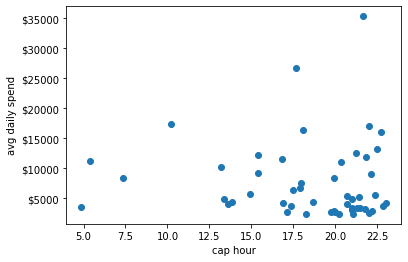

In [30]:
# pivot['cap_hour'].hist(bins = 20)
plt.scatter(pivot['cap_hour'],pivot['spend'])
plt.xlabel('cap hour')
plt.ylabel('avg daily spend')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('$%.0f'))

In [31]:
pvt = df_capping_joined.pivot_table(values = ['media_cost','spend','ssb_campaign_uuid','cap_hour'], index = ['date','dow'], columns = 'early_cap', aggfunc = {'media_cost':sum,'spend':sum,'cap_hour':np.mean,'ssb_campaign_uuid':lambda x:len(x.unique())})
pvt.columns = ['nonearly_cap_hour','early_cap_hour','nonearly_cap_media_cost','early_cap_media_cost','nonearly_cap_spend','early_cap_spend','nonearly_cap_campaign_ct','early_cap_campaign_ct']

pvt2 = pvt.reset_index().pivot_table(values = pvt.columns.tolist(), index = 'dow', aggfunc = np.mean)
pvt2.style.format({'early_cap_campaign_ct':'{:,.0f}','nonearly_cap_campaign_ct':'{:,.0f}','early_cap_hour':'{:,.1f}','nonearly_cap_hour':'{:,.1f}','early_cap_media_cost':'${:,.0f}','nonearly_cap_media_cost':'${:,.0f}','early_cap_spend':'${:,.0f}','nonearly_cap_spend':'${:,.0f}'})


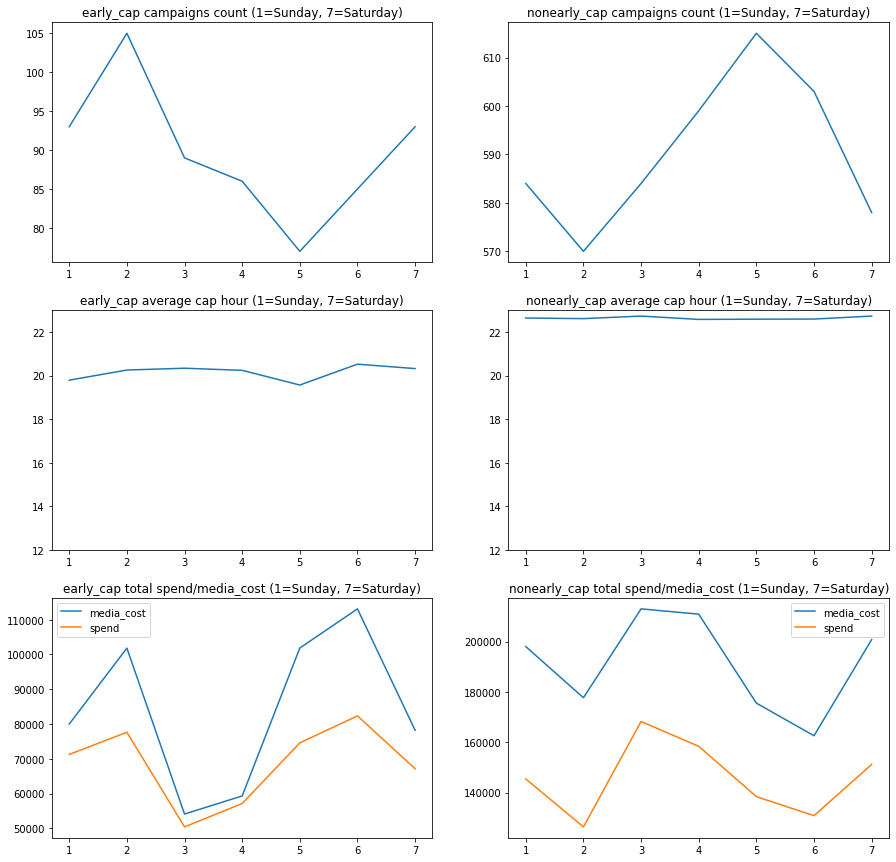

In [32]:
fig, ax = plt.subplots(3,2,figsize = (15,15))
ax[0,0].plot(pvt2[['early_cap_campaign_ct']])
ax[0,0].set_title('early_cap campaigns count (1=Sunday, 7=Saturday)')
ax[1,0].plot(pvt2[['early_cap_hour']])
ax[1,0].set_ylim([12,23])
ax[1,0].set_title('early_cap average cap hour (1=Sunday, 7=Saturday)')
ax[2,0].plot(pvt2[['early_cap_media_cost','early_cap_spend']])
ax[2,0].set_title('early_cap total spend/media_cost (1=Sunday, 7=Saturday)')
ax[2,0].legend(['media_cost','spend'])
ax[0,1].plot(pvt2[['nonearly_cap_campaign_ct']])
ax[0,1].set_title('nonearly_cap campaigns count (1=Sunday, 7=Saturday)')
ax[1,1].plot(pvt2[['nonearly_cap_hour']])
ax[1,1].set_title('nonearly_cap average cap hour (1=Sunday, 7=Saturday)')
ax[1,1].set_ylim([12,23])
ax[2,1].plot(pvt2[['nonearly_cap_media_cost','nonearly_cap_spend']])
ax[2,1].set_title('nonearly_cap total spend/media_cost (1=Sunday, 7=Saturday)')
ax[2,1].legend(['media_cost','spend'])

In [33]:
df_capping_joined['first_hour'] = df_capping_joined[df_capping_joined.impressions>0].groupby(['ssb_campaign_uuid','date'])['hour'].transform('min')
df_capping_joined_byday = df_capping_joined.pivot_table(values = ['cap_hour','first_hour','day_media_cost','day_spend','day_installs','media_plan_daily_budget','mp_daily_installs']
                                                       , index = ['ssb_campaign_uuid','campaign_name','buyer','date']
                                                       , aggfunc = max).reset_index()

df_capping_joined_byday['early_cap_install'] = (df_capping_joined_byday.day_installs > (.95*df_capping_joined_byday.mp_daily_installs)) & ~(df_capping_joined_byday.day_media_cost > (.95*df_capping_joined_byday.media_plan_daily_budget))
df_capping_joined_byday['early_cap_cost'] = ~(df_capping_joined_byday.day_installs > (.95*df_capping_joined_byday.mp_daily_installs)) & (df_capping_joined_byday.day_media_cost > (.95*df_capping_joined_byday.media_plan_daily_budget))
df_capping_joined_byday['early_cap_both'] = (df_capping_joined_byday.day_installs > (.95*df_capping_joined_byday.mp_daily_installs)) & (df_capping_joined_byday.day_media_cost > (.95*df_capping_joined_byday.media_plan_daily_budget))
df_capping_joined_byday['early_cap_install_1d'] = df_capping_joined_byday.early_cap_install.shift(1)
df_capping_joined_byday['early_cap_cost_1d'] = df_capping_joined_byday.early_cap_cost.shift(1)
df_capping_joined_byday['early_cap_both_1d'] = df_capping_joined_byday.early_cap_both.shift(1)
df_capping_joined_byday.head(10)

ssb_campaign_uuid                      campaign_name buyer  \
0  0005d4c9afa8f4ee29a173c2ef39c4bc  Noa/Yaron - MoonActive bundels US   RON   
1  0005d4c9afa8f4ee29a173c2ef39c4bc  Noa/Yaron - MoonActive bundels US   RON   
2  0005d4c9afa8f4ee29a173c2ef39c4bc  Noa/Yaron - MoonActive bundels US   RON   
3  0005d4c9afa8f4ee29a173c2ef39c4bc  Noa/Yaron - MoonActive bundels US   RON   
4  0005d4c9afa8f4ee29a173c2ef39c4bc  Noa/Yaron - MoonActive bundels US   RON   
5  0005d4c9afa8f4ee29a173c2ef39c4bc  Noa/Yaron - MoonActive bundels US   RON   
6  0005d4c9afa8f4ee29a173c2ef39c4bc  Noa/Yaron - MoonActive bundels US   RON   
7  0138908e7d019e752127048d0c270c16    1402413 480x320 a54d US MW -55%   RON   
8  0138908e7d019e752127048d0c270c16    1402413 480x320 a54d US MW -55%   RON   
9  0138908e7d019e752127048d0c270c16    1402413 480x320 a54d US MW -55%   RON   

        date  cap_hour  day_installs  day_media_cost  day_spend  first_hour  \
0 2021-07-27      20.0             0       12.734025        0.0         4.0   
1 2021-07-28      20.0             0       12.458847        0.0         4.0   
2 2021-07-29      20.0             0       12.094091        0.0         4.0   
3 2021-07-30      20.0             0       12.381411        0.0         4.0   
4 2021-07-31      20.0             0       12.866504        0.0         4.0   
5 2021-08-01      19.0             0       11.960782        0.0         4.0   
6 2021-08-02      20.0             0       12.414194        0.0         4.0   
7 2021-07-27      23.0             0       33.096546        0.0         0.0   
8 2021-07-28      23.0             0       34.466144        0.0         0.0   
9 2021-07-29      23.0             0       40.017597        0.0         0.0   

   media_plan_daily_budget  mp_daily_installs  early_cap_install  \
0                     10.0                NaN              False   
1                     10.0                NaN              False   
2                     10.0                NaN              False   
3                     10.0                NaN              False   
4                     10.0                NaN              False   
5                     10.0                NaN              False   
6                     10.0                NaN              False   
7                   5000.0                NaN              False   
8                   5000.0                NaN              False   
9                   5000.0                NaN              False   

   early_cap_cost  early_cap_both early_cap_install_1d early_cap_cost_1d  \
0            True           False                  NaN               NaN   
1            True           False                False              True   
2            True           False                False              True   
3            True           False                False              True   
4            True           False                False              True   
5            True           False                False              True   
6            True           False                False              True   
7           False           False                False              True   
8           False           False                False             False   
9           False           False                False             False   

  early_cap_both_1d  
0               NaN  
1             False  
2             False  
3             False  
4             False  
5             False  
6             False  
7             False  
8             False  
9             False

In [34]:
df_capping_joined.groupby('ssb_campaign_uuid')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without 

Text(0.5, 1.0, 'First hour of bids for campaigns that install+cost capped the previous day')

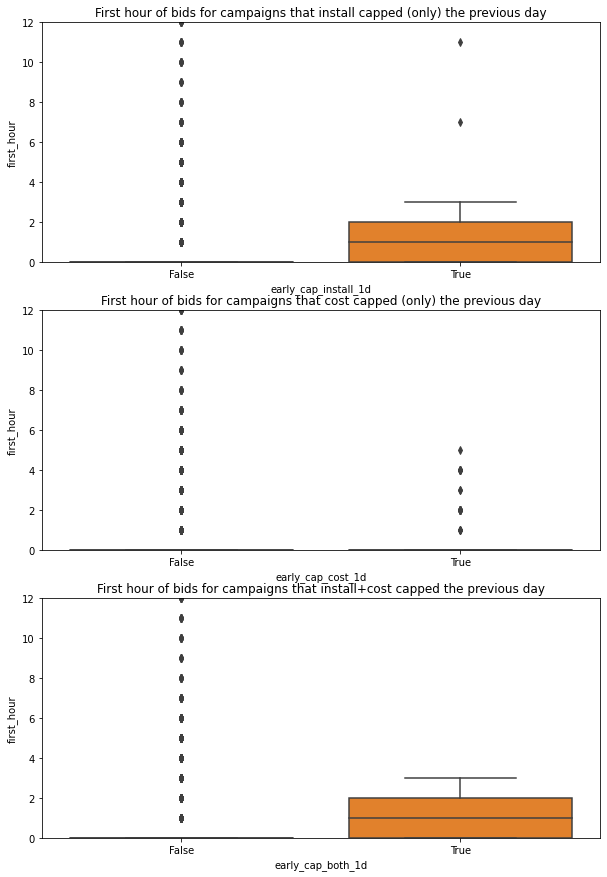

In [35]:

fig, ax = plt.subplots(3,1,figsize = (10,15))
sns.boxplot('early_cap_install_1d', 'first_hour', data = df_capping_joined_byday, ax = ax[0])
ax[0].set_ylim(0,12)
ax[0].set_title('First hour of bids for campaigns that install capped (only) the previous day')
sns.boxplot('early_cap_cost_1d', 'first_hour', data = df_capping_joined_byday, ax = ax[1])
ax[1].set_ylim(0,12)
ax[1].set_title('First hour of bids for campaigns that cost capped (only) the previous day')
sns.boxplot('early_cap_both_1d', 'first_hour', data = df_capping_joined_byday, ax = ax[2])
ax[2].set_ylim(0,12)
ax[2].set_title('First hour of bids for campaigns that install+cost capped the previous day')


Check against agg

In [36]:
df_agg_campaigns = bigquery_client.query(f"""
select
    ssb_campaign_uuid
    , date 
    , SUM(num_wins) as impressions
    , SUM(num_clicks) as clicks
    , SUM(num_installs) as installs
    , SUM(cost_net) as cost_net
    , SUM(revenue) as revenue 
FROM stats.mv_wins_campaign_1 
WHERE 
    date BETWEEN '{start_dt}' AND '{end_dt}' 
    AND ssb_buyer_id = 3549 
GROUP BY ssb_campaign_uuid, date
""").to_dataframe()
df_agg_campaigns

ssb_campaign_uuid        date  impressions  clicks  \
0     9b07b6d96782e14112140ff402271326  2021-07-30        46973    3956   
1     a31979b4a28a73862711186d57c476e0  2021-07-30       596864   84064   
2     ec32166fa4eda27c5235e71e5765e7a1  2021-07-30      2093402   60350   
3     26ae46e908d03fbe20c01f7fd804a788  2021-07-30      1107852   25946   
4     bf2889656216fe7f0191cb8ecbaba3e4  2021-07-30        90633    7836   
...                                ...         ...          ...     ...   
1341  9c7180192abd80a0cd4d15440e04ac55  2021-07-27        82648    1636   
1342  d3b1408721e726a89e34392b8562f61f  2021-07-29         1178      10   
1343  fc2ba0e560c59f4ee98f9e8b6f7d89d4  2021-07-29        50114     449   
1344  f1d182a7fabffea0694ae7287aa26c0d  2021-07-29       122493    4057   
1345  0224bbad97373496c369a8023df2a40c  2021-07-29         5611     288   

      installs     cost_net  revenue  
0          404   606.099039    928.0  
1          108   401.959856    313.3  
2           69   459.833627    386.2  
3         1833  4183.974190   4531.0  
4         1072   730.725088   1263.4  
...        ...          ...      ...  
1341         7    11.769700     21.0  
1342         0     2.506011      0.0  
1343         1    18.924754      8.0  
1344         2    44.282964      7.0  
1345         4   101.248303     70.0  

[1346 rows x 7 columns]

In [37]:
df_agg_campaigns['cpi'] = df_agg_campaigns.cost_net/df_agg_campaigns.installs

In [60]:
dt_campaigns_offers = df_campaigns_offers.loc[df_campaigns_offers.ssb_buyer_id == 3549, ['ssb_campaign_uuid','campaign_name', 'cpi','auto_pilot_cpi_factor']]
df_agg_campaigns_days_joined = pd.merge(df_agg_campaigns, dt_campaigns_offers, on = 'ssb_campaign_uuid', suffixes = ('_actual','_target'))
df_agg_campaigns_days_joined['actual_target_ratio'] = round(df_agg_campaigns_days_joined.cpi_actual/df_agg_campaigns_days_joined.cpi_target,2)
df_agg_campaigns_days_joined[df_agg_campaigns_days_joined.ssb_campaign_uuid == '4c7f5d9964abdca5793b3d48f13fe6f9']

ssb_campaign_uuid        date  impressions  clicks  \
1106  4c7f5d9964abdca5793b3d48f13fe6f9  2021-08-01      2157111  106600   
1107  4c7f5d9964abdca5793b3d48f13fe6f9  2021-07-27      2463305  126354   
1108  4c7f5d9964abdca5793b3d48f13fe6f9  2021-07-28      2487455  126678   
1109  4c7f5d9964abdca5793b3d48f13fe6f9  2021-07-31      2103184  105424   
1110  4c7f5d9964abdca5793b3d48f13fe6f9  2021-07-30      2475882  126389   
1111  4c7f5d9964abdca5793b3d48f13fe6f9  2021-07-29      2473465  126907   
1112  4c7f5d9964abdca5793b3d48f13fe6f9  2021-08-02      2165315  105276   

      installs      cost_net  revenue  cpi_actual  \
1106     17491  31831.986244  41114.7    1.819907   
1107     22635  38878.939501  42887.7    1.717647   
1108     22561  41715.622362  44579.1    1.849015   
1109     17647  31442.366062  33849.0    1.781740   
1110     21458  43711.176303  34847.7    2.037057   
1111     22303  44931.924954  36406.8    2.014614   
1112     16318  32080.746577  41448.9    1.965973   

                                 campaign_name  cpi_target  \
1106  Position Mobile – Weather Home – US – UA         1.5   
1107  Position Mobile – Weather Home – US – UA         1.5   
1108  Position Mobile – Weather Home – US – UA         1.5   
1109  Position Mobile – Weather Home – US – UA         1.5   
1110  Position Mobile – Weather Home – US – UA         1.5   
1111  Position Mobile – Weather Home – US – UA         1.5   
1112  Position Mobile – Weather Home – US – UA         1.5   

      auto_pilot_cpi_factor  actual_target_ratio  
1106                    1.5                 1.21  
1107                    1.5                 1.15  
1108                    1.5                 1.23  
1109                    1.5                 1.19  
1110                    1.5                 1.36  
1111                    1.5                 1.34  
1112                    1.5                 1.31

In [62]:
df_agg_campaigns_joined = df_agg_campaigns_days_joined.groupby(['ssb_campaign_uuid','campaign_name','cpi_target','auto_pilot_cpi_factor'])['impressions','clicks','installs','cost_net','revenue'].sum().reset_index()
df_agg_campaigns_joined['cpi_actual'] = df_agg_campaigns_joined['cost_net']/df_agg_campaigns_joined['installs']
df_agg_campaigns_joined['actual_target_ratio'] = round(df_agg_campaigns_joined.cpi_actual/df_agg_campaigns_joined.cpi_target,2)
df_agg_campaigns_joined

<ipython-input-62-6bc725b7d17f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_agg_campaigns_joined = df_agg_campaigns_days_joined.groupby(['ssb_campaign_uuid','campaign_name','cpi_target','auto_pilot_cpi_factor'])['impressions','clicks','installs','cost_net','revenue'].sum().reset_index()


ssb_campaign_uuid  \
0    0282f78e216dfd3118d71a5fe5ff49bf   
1    0296ac714f843c1ecb94c5bd3c63a1f2   
2    041066b01d49f1a4ade45a6aaf86c8c6   
3    052f98115f3f0c873bebe40fd3368e74   
4    058d1b7ac105ca32cc5fe34b2cf3abb8   
..                                ...   
151  fc2ba0e560c59f4ee98f9e8b6f7d89d4   
152  fd7d50a6a6412fd090e43abe3dbc774e   
153  fe64a9f1d0e4986d64879d60781f14cf   
154  ff53565005448c10ef8764492889feb7   
155  ff5f6bfc2de6ff0dc959dc9300ed4f83   

                                     campaign_name  cpi_target  \
0                     Android-Twitter-Twitter-TR-4        2.25   
1     Android-Scopely-Star Trek Fleet Command-US-4       15.00   
2              Android-PeerTrade-BitcoinTrade-BR-2        0.40   
3                     Android-Twitter-Twitter-IE-4        8.50   
4                     Android-Twitter-Twitter-AR-2        0.70   
..                                             ...         ...   
151                   Android-Twitter-Twitter-PT-4        8.00   
152                  Android-WPromote-HBO Max-US-4        3.00   
153  Particle Media - News Break - US - Cricket UA        1.00   
154                       Android-Ripio-Ripio-AR-3        0.40   
155               Android-Grupo Coppel-Coppel-MX-2        0.50   

     auto_pilot_cpi_factor  impressions  clicks  installs     cost_net  \
0                      1.0        85671    8142        14    77.350775   
1                      1.6       417454    5460         7  1029.182067   
2                      0.5      1262722   35077      5961  1117.957284   
3                      1.2      1262922   23449        26   380.602927   
4                      1.2      2227516  195716      9397  6912.496419   
..                     ...          ...     ...       ...          ...   
151                    1.0       178006    1483         8    64.215982   
152                    1.2      8264244   27762      1613  3078.451260   
153                    0.6       408099   12326      1537   876.367873   
154                    1.5       290401    2544        23    39.383723   
155                    0.3      2171843   98265      8238   581.204911   

     revenue  cpi_actual  actual_target_ratio  
0       67.5    5.525055                 2.46  
1      105.0  147.026010                 9.80  
2     2603.5    0.187545                 0.47  
3      221.0   14.638574                 1.72  
4     8011.2    0.735607                 1.05  
..       ...         ...                  ...  
151     64.0    8.026998                 1.00  
152   4977.0    1.908525                 0.64  
153   2540.0    0.570181                 0.57  
154      9.6    1.712336                 4.28  
155   5170.0    0.070552                 0.14  

[156 rows x 11 columns]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/daniel.ryu/Library/Python/3.8/lib/python/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<AxesSubplot:xlabel='auto_pilot_cpi_factor', ylabel='actual_target_ratio'>

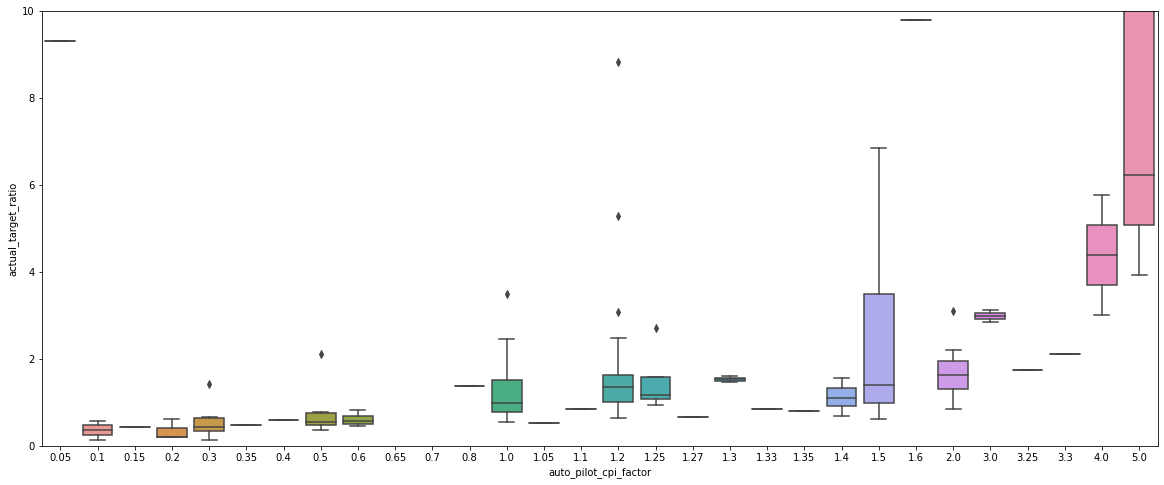

In [65]:
plt.figure(figsize = (20,8))
plt.gca().set_ylim(0,10)
sns.boxplot('auto_pilot_cpi_factor','actual_target_ratio', data = df_agg_campaigns_joined)